# Init

In [ ]:
# CAUTION: This version is a must
!pip install tensorflow==2.15.0
import tensorflow as tf
print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
# Download from https://zenodo.org/records/13142997, then unzip to your directory
!unzip cropped_dials_students_abc.zip -d /content

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/cropped_dials_students_abc/2828_3_dashboard.png  
  inflating: /content/cropped_dials_students_abc/2828_3_heading_indicator.png  
  inflating: /content/cropped_dials_students_abc/2828_3_turn_coordinator.png  
  inflating: /content/cropped_dials_students_abc/2828_3_vertical_speed_indicator.png  
  inflating: /content/cropped_dials_students_abc/2829_3_airspeed_indicator.png  
  inflating: /content/cropped_dials_students_abc/2829_3_altimeter.png  
  inflating: /content/cropped_dials_students_abc/2829_3_attitude_indicator.png  
  inflating: /content/cropped_dials_students_abc/2829_3_dashboard.png  
  inflating: /content/cropped_dials_students_abc/2829_3_heading_indicator.png  
  inflating: /content/cropped_dials_students_abc/2829_3_turn_coordinator.png  
  inflating: /content/cropped_dials_students_abc/2829_3_vertical_speed_indicator.png  
  inflating: /content/cropped_dials_students_abc/283_1_airspeed_indicator.png  
  i

#1.ResNet50 Features

In [ ]:
# Provide the model path if it is not directly in the working directory
temp_model = tf.keras.models.load_model("model_resnet50")
layer_names=[layer.name for layer in temp_model.layers]

In [ ]:
import cv2
import numpy as np
from scipy.special import softmax
from google.colab.patches import cv2_imshow

feature_layer_idx = 5
img_height = 88
img_width = 88

intermediate_model = tf.keras.Model(inputs=temp_model.layers[0].input,
                              outputs=temp_model.layers[feature_layer_idx].output)
print(intermediate_model.summary())

features = intermediate_model.predict(np.expand_dims(img, axis=0), verbose=0)
print("features: ", features)
print("features.shape:", features.shape)
print(np.count_nonzero(features))

In [ ]:
import os
import pandas as pd
import shutil

# Change paths as necessary
meta_data_fpath = "_metadata_colab.csv"
data_dir = "cropped_dials_students_abc/"
savepath = "/dataset/"

meta_df = pd.read_csv(meta_data_fpath, sep=";")

In [ ]:
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow

import cv2
from scipy.special import softmax

import time

def get_resnet_features(meta_df, data_dir, img_height, img_width, feature_layer_idx):
  """
  Extract ResNet50 features for images in the data directory.

  Args:
    meta_df: DataFrame containing metadata (filename, classinfo).
    data_dir: Directory containing the images.
    img_height: Height to resize images to.
    img_width: Width to resize images to.
    feature_layer_idx: Index of the feature layer in the ResNet50 model.

  Returns:
    DataFrame with filename, classinfo, and ResNet50 features.
  """

  temp_model = tf.keras.models.load_model("model_resnet50")
  intermediate_model = tf.keras.Model(inputs=temp_model.layers[0].input,
                                outputs=temp_model.layers[feature_layer_idx].output)

  features_list = []
  features_np = []
  start_ = time.time()
  for index, row in meta_df.iterrows():
    if index % 1000 == 0:
      print(f"Processed {index} images. Time elapsed: {time.time() - start_}")

    filename = data_dir+row['img_path'].split("\\")[-1]
    classinfo = row['class_name']
    bbox = row['bbox_coverage']

    if not os.path.exists(filename):
      print(f"File not found: {filename}")
      continue

    img = cv2.imread(filename)
    """cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()"""
    img = cv2.resize(img, (img_height, img_width))
    features = intermediate_model.predict(np.expand_dims(img, axis=0), verbose=0)

    features_np.append(features.flatten())

    features_list.append({
        'img_path': filename,
        'class_name': classinfo,
        'bbox_coverage': bbox,
        'features': features.flatten()  # Flatten the features array
    })

  print(f"Time elapsed: {time.time() - start_}")

  return pd.DataFrame(features_list), np.array(features_np)

In [ ]:
# Call the function to get features
features_df, features_np = get_resnet_features(meta_df, data_dir, img_height, img_width, feature_layer_idx)
features_df.to_csv(savepath+"resnet50_features.csv", index=False)
print("features_np.shape: ", features_np.shape)
print("features_np: ", features_np)
np.save(savepath+"resnet50_features_np.npy", features_np)

# 2.Confidence Elicitation

In [ ]:
import pandas as pd
import numpy as np
def get_resnet_logits(meta_df, data_dir, img_height, img_width, feature_layer_idx):
  """
  Extract ResNet50 features (or logits if feature_layer_idx=-1)
  for images in the data directory.

  Args:
    meta_df: DataFrame containing metadata (filename, classinfo).
    data_dir: Directory containing the images.
    img_height: Height to resize images to.
    img_width: Width to resize images to.
    feature_layer_idx: Index of the feature layer in the ResNet50 model.
                       If -1, extract logits from the final layer.

  Returns:
    DataFrame with filename, classinfo, and ResNet50 features/logits.
  """

  temp_model = tf.keras.models.load_model("model_resnet50")
  if feature_layer_idx == -1:
    intermediate_model = temp_model  # Use the full model to get logits
  else:
    intermediate_model = tf.keras.Model(inputs=temp_model.layers[0].input,
                                  outputs=temp_model.layers[feature_layer_idx].output)

  features_list = []
  start_ = time.time()
  for index, row in meta_df.iterrows():
    if index % 1000 == 0:
      print(f"Processed {index} images. Time elapsed: {time.time() - start_}")

    filename = data_dir+row['img_path'].split("\\")[-1]
    classinfo = row['class_name']
    bbox = row['bbox_coverage']

    if not os.path.exists(filename):
      print(f"File not found: {filename}")
      continue

    img = cv2.imread(filename)
    img = cv2.resize(img, (img_height, img_width))
    features = intermediate_model.predict(np.expand_dims(img, axis=0), verbose=0)

    if feature_layer_idx == -1:
      features = softmax(features.flatten())  # Apply softmax to logits
    else:
      features = features.flatten()

    features_list.append({
        'img_path': filename,
        'class_name': classinfo,
        'bbox_coverage': bbox,
        'features': features
    })

  print(f"Time elapsed: {time.time() - start_}")

  return pd.DataFrame(features_list)

In [ ]:
import pandas as pd
import numpy as np

# Get logits (softmaxed)
logits_df = get_resnet_logits(meta_df, data_dir, img_height, img_width, feature_layer_idx=-1)
logits_df.to_csv(savepath+"resnet50_logits.csv", index=False)

Processed 0 images. Time elapsed: 0.10105347633361816
Processed 1000 images. Time elapsed: 177.1583378314972
Processed 2000 images. Time elapsed: 344.3066825866699
Processed 3000 images. Time elapsed: 513.7805109024048
Processed 4000 images. Time elapsed: 681.9976754188538
Processed 5000 images. Time elapsed: 854.4729566574097
Processed 6000 images. Time elapsed: 1022.8091027736664
Processed 7000 images. Time elapsed: 1193.2144463062286
Processed 8000 images. Time elapsed: 1359.0881671905518
Processed 9000 images. Time elapsed: 1534.6183185577393
Processed 10000 images. Time elapsed: 1704.292160987854
Processed 11000 images. Time elapsed: 1881.807538986206
Processed 12000 images. Time elapsed: 2052.7859585285187
Processed 13000 images. Time elapsed: 2226.5814871788025
Processed 14000 images. Time elapsed: 2399.4614021778107
Processed 15000 images. Time elapsed: 2574.9607944488525
Processed 16000 images. Time elapsed: 2743.7117755413055
Processed 17000 images. Time elapsed: 2914.6006138

In [ ]:
import numpy as np
def confidence_input_elicitation(softmax_outputs, thres=0.5):
  """
  Performs confidence input elicitation based on softmax outputs.
  If max confidence is less than thres, it is considered an outlier.

  Args:
    softmax_outputs: A numpy array of shape (n_samples, n_classes) containing the softmax probabilities for each sample.

  Returns:
    A numpy array of shape (n_samples,) containing the confidence scores for each sample.
  """
  #num_class = softmax_outputs.shape[1]

  # Calculate the maximum softmax probability for each sample
  max_probabilities = np.max(softmax_outputs, axis=1)

  idx_list = []
  for i in range(len(max_probabilities)):
    if max_probabilities[i] < thres:
      idx_list.append(i)

  return idx_list


In [ ]:
import pandas as pd
import numpy as np

logits_df = pd.read_csv(savepath+"resnet50_logits.csv")
logits_df['features'] = logits_df['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
logits_df['features']
#

,features
0,"[0.016247515, 0.00022942699, 0.00098259549, 2...."
1,"[1.3967739e-08, 2.6313879e-05, 5.0882758e-05, ..."
2,"[0.027519492, 0.45054847, 1.5530342e-06, 4.208..."
3,"[0.00095743185, 0.85864615, 0.0053806542, 3.80..."
4,"[1.2241784e-07, 1.9656436e-05, 6.0044008e-06, ..."
...,...
25304,"[0.0011844618, 0.00048839714, 0.47297126, 0.01..."
25305,"[0.28278667, 0.66296005, 5.8382602e-07, 2.9832..."
25306,"[0.095000498, 0.00022511947, 0.00014465813, 1...."
25307,"[0.01407374, 0.1330855, 0.01781956, 0.1998573,..."


In [ ]:
logits = logits_df['features'].apply(lambda x: np.array(x)).tolist()
logits = np.array(logits)
print(logits[:10,:])
logits.shape

[[1.62475150e-02 2.29426990e-04 9.82595490e-04 2.76476000e-05
  8.64011470e-04 9.81402990e-01 1.46461960e-04 9.93304780e-05]
 [1.39677390e-08 2.63138790e-05 5.08827580e-05 9.99797760e-01
  1.60927460e-09 9.72200870e-05 2.69987940e-05 7.88490470e-07]
 [2.75194920e-02 4.50548470e-01 1.55303420e-06 4.20819920e-06
  7.37251660e-04 2.73848480e-04 2.91654320e-05 5.20886000e-01]
 [9.57431850e-04 8.58646150e-01 5.38065420e-03 3.80900160e-05
  2.76718200e-06 2.52010160e-03 1.28225950e-01 4.22877310e-03]
 [1.22417840e-07 1.96564360e-05 6.00440080e-06 9.98521030e-01
  4.58873610e-09 1.44243400e-03 6.53230790e-06 4.26941920e-06]
 [4.73788470e-03 8.21392750e-05 1.76499220e-04 1.94922220e-06
  2.71312160e-04 9.94647800e-01 1.63474920e-05 6.61111260e-05]
 [1.41111843e-06 3.14609351e-04 9.99316096e-01 7.54323264e-05
  9.31289378e-06 1.13108130e-04 1.57325005e-04 1.26647865e-05]
 [3.23120620e-03 7.55641530e-02 8.72837190e-03 3.62260690e-03
  1.97883260e-05 8.98524700e-01 1.01721170e-02 1.37004200e-04]


(25309, 8)

In [ ]:
logits_df_orj = logits_df.copy()
logits_df['bbox_coverage'] = logits_df['bbox_coverage'].apply(lambda x: "full" if "full" in x else "noise")
print(logits_df.head())
class_names = logits_df["bbox_coverage"].unique().tolist()
print(class_names)

                                            img_path          class_name  \
0  cropped_dials_students_abc/1_1_airspeed_indica...  airspeed_indicator   
1       cropped_dials_students_abc/1_1_dashboard.png           dashboard   
2       cropped_dials_students_abc/1_1_altimeter.png           altimeter   
3  cropped_dials_students_abc/1_1_attitude_indica...  attitude_indicator   
4       cropped_dials_students_abc/2_1_dashboard.png           dashboard   

  bbox_coverage                                           features  
0          full  [0.016247515, 0.00022942699, 0.00098259549, 2....  
1          full  [1.3967739e-08, 2.6313879e-05, 5.0882758e-05, ...  
2          full  [0.027519492, 0.45054847, 1.5530342e-06, 4.208...  
3          full  [0.00095743185, 0.85864615, 0.0053806542, 3.80...  
4          full  [1.2241784e-07, 1.9656436e-05, 6.0044008e-06, ...  
['full', 'noise']


In [ ]:
logits_df['bbox_coverage'].value_counts()

,count
bbox_coverage,
full,23052
noise,2257


In [ ]:
logits_df_orj['bbox_coverage'] = logits_df_orj['bbox_coverage'].apply(lambda x: "full" if "full" in x else x)
logits_df_orj['bbox_coverage'].value_counts()

,count
bbox_coverage,
full,23052
none,1238
multiple_objects,672
partial,347


In [ ]:
import numpy as np

# Extract ground truth labels (True for noise, False for full)
ground_truth = logits_df['bbox_coverage'] == 'noise'

thres_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
macro_f1_list = []

for thres in thres_list:
  print("\n\n=====Threshold: ", thres)
  outlier_idx = confidence_input_elicitation(logits, thres=thres)

  print("\nOutliers detected: ")
  print(logits_df_orj['bbox_coverage'][outlier_idx].value_counts())
  print(f"\nNumber of outliers: {len(outlier_idx)}")

  # Create a boolean mask for outliers
  outlier_mask = np.zeros(len(logits_df), dtype=bool)
  outlier_mask[outlier_idx] = True

  print("\nNot detected: ")
  print(logits_df_orj['bbox_coverage'][~outlier_mask].value_counts())

  # Generate classification report
  report = classification_report(ground_truth, outlier_mask)
  macro_f1_list.append(float(report.split("\n")[-3].split()[-2]))
  print(report)


print("\n\nthres_list: ", thres_list)
print("macro_f1_list: ", macro_f1_list)
print()



=====Threshold:  0.9

Outliers detected: 
bbox_coverage
full                11080
none                  909
multiple_objects      620
partial               122
Name: count, dtype: int64

Number of outliers: 12731

Not detected: 
bbox_coverage
full                11972
none                  329
partial               225
multiple_objects       52
Name: count, dtype: int64
              precision    recall  f1-score   support

       False       0.95      0.52      0.67     23052
        True       0.13      0.73      0.22      2257

    accuracy                           0.54     25309
   macro avg       0.54      0.63      0.45     25309
weighted avg       0.88      0.54      0.63     25309



=====Threshold:  0.8

Outliers detected: 
bbox_coverage
full                8078
none                 793
multiple_objects     526
partial               92
Name: count, dtype: int64

Number of outliers: 9489

Not detected: 
bbox_coverage
full                14974
none                  445
partia

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

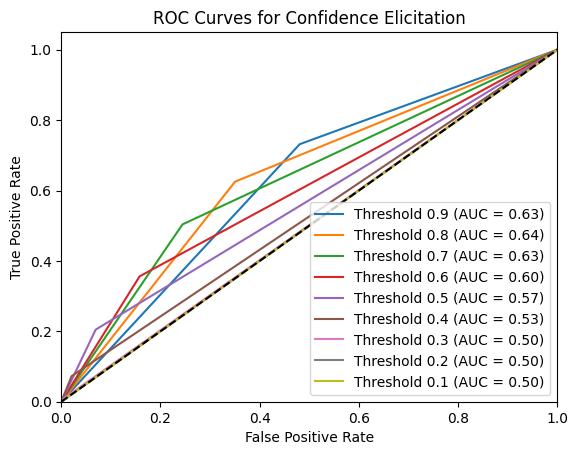

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

thres_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

plt.figure()
for thres in thres_list:
  outlier_idx = confidence_input_elicitation(logits, thres=thres)
  outlier_mask = np.zeros(len(logits_df), dtype=bool)
  outlier_mask[outlier_idx] = True

  fpr, tpr, _ = roc_curve(ground_truth, outlier_mask)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label=f"Threshold {thres} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Confidence Elicitation')
plt.legend(loc="lower right")
plt.show()


# 3.Semi-Supervised BBox Classification

In [ ]:
# Multi-class Comparison
# Source: Modified from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html, Aug.2024.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def classifier_ellicitation(X_train, X_test, y_train, y_test, widen_by=2, shrink_by=128, suptitle="From Features"):
  class_names = np.unique(y_train).tolist()
  class_labels = [c[0].upper() for c in class_names]
  num_features = X_train.shape[1]
  print(f"Number of features: {num_features}")

  wide_units = num_features * widen_by
  narrow_units = num_features // shrink_by
  print(f"Wide units: {wide_units}, Narrow units: {narrow_units}")

  names = [
      "Nearest Neighbors, \nk=3",
      "Decision Tree, \nMax Depth=5",
      "Random Forest, \nMax Depth=5",

      f"Neural Net, \nReLU, {wide_units} Units",
      f"Neural Net, \nTanh, {wide_units} Units",
      f"Neural Net, \nLogistic, {wide_units} Units",

      f"Neural Net, \nReLU, {narrow_units} Units",
      f"Neural Net, \nTanh, {narrow_units} Units",
      f"Neural Net, \nLogistic, {narrow_units} Units",
  ]

  n_iter_no_change = 3
  max_iter = 1000

  classifiers = [
      KNeighborsClassifier(3),
      DecisionTreeClassifier(max_depth=5, random_state=42),
      RandomForestClassifier(
          max_depth=5, n_estimators=10, max_features=1, random_state=42
      ),
      # hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)
      # activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
      # solver:   {‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
      # batch_size: int, default=’auto’, When set to “auto”, batch_size=min(200, n_samples).
      # max_iter: int, default=200
      # early_stopping: bool, default=False,
      #   If True, it will automatically set aside 10% of training data as validation
      #   and terminate training when validation score is not improving by at least
      #   tol for n_iter_no_change consecutive epochs.
      # n_iter_no_changeint, default=10
      MLPClassifier(activation="relu", alpha=1, hidden_layer_sizes=(wide_units,), max_iter=max_iter, n_iter_no_change=n_iter_no_change, random_state=42, early_stopping=True, verbose=True),
      MLPClassifier(activation="tanh", alpha=1, hidden_layer_sizes=(wide_units,), max_iter=max_iter, n_iter_no_change=n_iter_no_change, random_state=42, early_stopping=True, verbose=True),
      MLPClassifier(activation="logistic", alpha=1, hidden_layer_sizes=(wide_units,), max_iter=max_iter, n_iter_no_change=n_iter_no_change, random_state=42, early_stopping=True, verbose=True),

      MLPClassifier(activation="relu", alpha=1, hidden_layer_sizes=(narrow_units,), max_iter=max_iter, n_iter_no_change=n_iter_no_change, random_state=42, early_stopping=True, verbose=True),
      MLPClassifier(activation="tanh", alpha=1, hidden_layer_sizes=(narrow_units,), max_iter=max_iter, n_iter_no_change=n_iter_no_change, random_state=42, early_stopping=True, verbose=True),
      MLPClassifier(activation="logistic", alpha=1, hidden_layer_sizes=(narrow_units,), max_iter=max_iter, n_iter_no_change=n_iter_no_change, random_state=42, early_stopping=True, verbose=True),
  ]

  fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)
  score_dict = {}
  pred_dict = {}
  times_dict = {}
  for i, ax, name, clf in zip(range(len(names)), axs.flatten(), names, classifiers):
        print(f"\n\n{name}")

        start_ = time.time()
        clf.fit(X_train, y_train)
        times_dict[name] = {"train_time": time.time() - start_}

        # mean accuracy
        score = clf.score(X_test, y_test)
        score_dict[name] = score
        print(f"{name} score: {score}")

        start_ = time.time()
        y_hat = clf.predict(X_test)
        pred_dict[name] = y_hat
        times_dict[name]["inference_time_per_sample"] = (time.time() - start_)/len(y_test)

        print("Time: ", times_dict[name])

        report = classification_report(y_test, y_hat, target_names=class_names)
        print(f"{name} classification report:\n{report}")

        cm = confusion_matrix(y_test, y_hat, labels=class_names)
        print(f"{name} confusion matrix:\n{cm}")

        # Normalizes confusion matrix over the true (rows), predicted (columns)
        # conditions or all the population. If None, confusion matrix will not be normalized.
        cm_normalized = confusion_matrix(y_test, y_hat, labels=class_names, normalize="true")
        print(f"{name} normalized confusion matrix:\n{cm_normalized}")

        sns.heatmap(cm_normalized, ax=ax, annot=True,  fmt='.2f', square=True, cbar=False, cmap="Blues", linewidth=1, linecolor="k")

        if i >= 6:
          ax.set(xlabel="Predicted", ylabel="")
          ax.set_xticklabels(class_labels)
        if i % 3 == 0:
          ax.set(xlabel="", ylabel="Ground Truth")
          ax.set_yticklabels(class_labels)
        if i >= 6 and i % 3 == 0:
          ax.set(xlabel="Predicted", ylabel="Ground Truth")
          ax.set_xticklabels(class_labels)
          ax.set_yticklabels(class_labels)

        ax.set_yticklabels(class_labels)
        ax.set_title(name)

  fig.suptitle(suptitle)
  plt.tight_layout()
  plt.show()

  return score_dict, pred_dict, times_dict
  #return None, None, None

## 3.1.From Features

In [ ]:
import pandas as pd
import numpy as np

features_df = pd.read_csv(savepath+"resnet50_features.csv")
features_df['features'] = features_df['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
features_df['features']

<ipython-input-17-ce90ba8d1c9f>:5: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  features_df['features'] = features_df['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))


,features
0,"[1.06659, 0.0, 0.01258414]"
1,"[1.8986524, 1.1368073, 0.0]"
2,"[0.00309781, 0.0, 0.0]"
3,"[0.01306774, 1.2002249, 0.0]"
4,"[3.3149009, 0.0, 0.0]"
...,...
25304,"[0.0, 0.0, 0.0]"
25305,"[0.1106163, 0.0, 0.08723161]"
25306,"[0.61633235, 0.0, 0.04173703]"
25307,"[0.20714805, 0.15824479, 0.0]"


In [ ]:
features_df['bbox_coverage'].tolist()[:10]

['full_tight',
 'full_tight',
 'full_tight',
 'full_tight',
 'full_tight',
 'full_tight',
 'none',
 'none',
 'full_not_tight',
 'none']

In [ ]:
features_npy = np.load(savepath+"resnet50_features_np.npy")
print(features_npy.shape)
features_npy

(25309, 2048)


array([[1.06659   , 0.        , 0.01258414, ..., 0.23756473, 0.        ,
        0.05652715],
       [1.8986524 , 1.1368073 , 0.        , ..., 0.8745266 , 0.54687226,
        3.079581  ],
       [0.00309781, 0.        , 0.        , ..., 0.        , 0.        ,
        0.71508455],
       ...,
       [0.61633235, 0.        , 0.04173703, ..., 0.        , 0.        ,
        0.        ],
       [0.20714805, 0.15824479, 0.        , ..., 0.        , 0.        ,
        0.06338564],
       [0.21344656, 0.15891157, 0.        , ..., 0.        , 0.        ,
        0.06744548]], dtype=float32)

In [ ]:
# Prepare dataset
features_df['bbox_coverage'] = features_df['bbox_coverage'].apply(lambda x: "full" if "full" in x else x)
print(features_df.head())
class_names = features_df["bbox_coverage"].unique().tolist()
print(class_names)

                                            img_path          class_name  \
0  cropped_dials_students_abc/1_1_airspeed_indica...  airspeed_indicator   
1       cropped_dials_students_abc/1_1_dashboard.png           dashboard   
2       cropped_dials_students_abc/1_1_altimeter.png           altimeter   
3  cropped_dials_students_abc/1_1_attitude_indica...  attitude_indicator   
4       cropped_dials_students_abc/2_1_dashboard.png           dashboard   

  bbox_coverage                      features  
0          full    [1.06659, 0.0, 0.01258414]  
1          full   [1.8986524, 1.1368073, 0.0]  
2          full        [0.00309781, 0.0, 0.0]  
3          full  [0.01306774, 1.2002249, 0.0]  
4          full         [3.3149009, 0.0, 0.0]  
['full', 'none', 'partial', 'multiple_objects']


### Typical Partition: %80 train, %20 test

In [ ]:
# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = features_npy
y = features_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
train_rate = 0.8
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))


Train set distribution:
 {'full': 18434, 'multiple_objects': 553, 'none': 977, 'partial': 283} Total: 20247

Test set distribution:
 {'full': 4618, 'multiple_objects': 119, 'none': 261, 'partial': 64} Total: 5062

Train set distribution (%):
 {'full': 0.9104558700054329, 'multiple_objects': 0.02731268829950116, 'none': 0.04825406233022176, 'partial': 0.013977379364844174}

Test set distribution (%):
 {'full': 0.9122876333465033, 'multiple_objects': 0.023508494666139867, 'none': 0.05156064796523113, 'partial': 0.012643224022125641}


Number of features: 2048
Wide units: 4096, Narrow units: 16


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9899249308573687
Time:  {'train_time': 0.041585445404052734, 'inference_time_per_sample': 0.0035652427605516305}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       1.00      1.00      1.00      4618
multiple_objects       0.95      0.93      0.94       119
            none       0.94      0.92      0.93       261
         partial       0.83      0.81      0.82        64

        accuracy                           0.99      5062
       macro avg       0.93      0.91      0.92      5062
    weighted avg       0.99      0.99      0.99      5062

Nearest Neighbors, 
k=3 confusion matrix:
[[4609    0    4    5]
 [   0  111    7    1]
 [  12    5  239    5]
 [   8    1    3   52]]
Nearest Neighbors, 
k=3 normalized confusion matrix:
[[9.98051104e-01 0.00000000e+00 8.66175834e-04 1.08271979e-03]
 [0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 normalized confusion matrix:
[[1.         0.         0.         0.        ]
 [0.6302521  0.3697479  0.         0.        ]
 [0.98850575 0.01149425 0.         0.        ]
 [1.         0.         0.         0.        ]]


Neural Net, 
ReLU, 4096 Units
Iteration 1, loss = 3.35895493
Validation score: 0.985679
Iteration 2, loss = 0.80671626
Validation score: 0.988642
Iteration 3, loss = 0.36238080
Validation score: 0.985679
Iteration 4, loss = 0.22809023
Validation score: 0.984691
Iteration 5, loss = 0.16836841
Validation score: 0.985185
Iteration 6, loss = 0.13254020
Validation score: 0.987160
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
Neural Net, 
ReLU, 4096 Units score: 0.9855788225997629
Time:  {'train_time': 208.29289937019348, 'inference_time_per_sample': 0.0006018269443549643}
Neural Net, 
ReLU, 4096 Units classification report:
                  precision    recall  f1-score   support

            full    

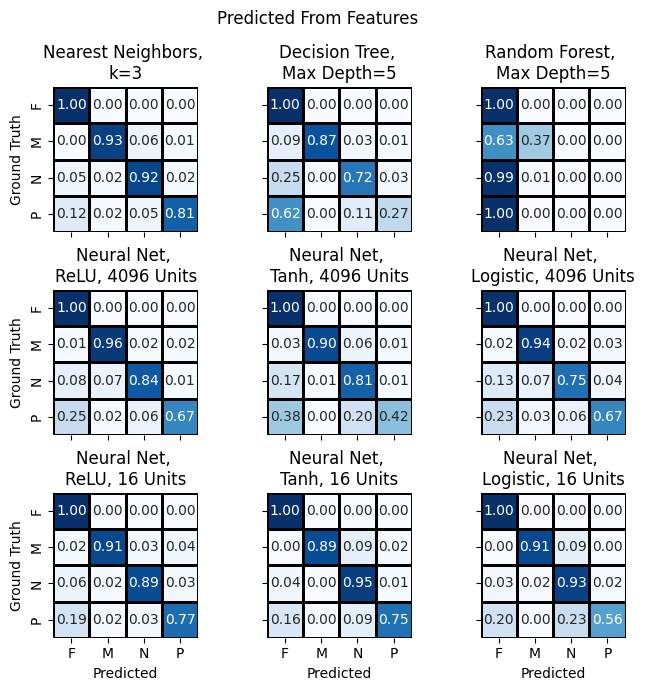

In [ ]:
# ~14 dk, %80 train, %20 test
score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=2, shrink_by=128, suptitle="Predicted From Features")

In [ ]:
score_dict

{'Nearest Neighbors, \nk=3': 0.9899249308573687,
 'Decision Tree, \nMax Depth=5': 0.9713551955748716,
 'Random Forest, \nMax Depth=5': 0.9209798498617148,
 'Neural Net, \nReLU, 4096 Units': 0.9855788225997629,
 'Neural Net, \nTanh, 4096 Units': 0.9802449624654287,
 'Neural Net, \nLogistic, 4096 Units': 0.9798498617147372,
 'Neural Net, \nReLU, 16 Units': 0.98893717898064,
 'Neural Net, \nTanh, 16 Units': 0.9895298301066772,
 'Neural Net, \nLogistic, 16 Units': 0.9873567759778744}

In [ ]:
times_dict

{'Nearest Neighbors, \nk=3': {'train_time': 0.041585445404052734,
  'inference_time_per_sample': 0.0035652427605516305},
 'Decision Tree, \nMax Depth=5': {'train_time': 28.56285333633423,
  'inference_time_per_sample': 1.5566915167692103e-06},
 'Random Forest, \nMax Depth=5': {'train_time': 0.26791882514953613,
  'inference_time_per_sample': 5.4279554978230875e-06},
 'Neural Net, \nReLU, 4096 Units': {'train_time': 208.29289937019348,
  'inference_time_per_sample': 0.0006018269443549643},
 'Neural Net, \nTanh, 4096 Units': {'train_time': 180.4342963695526,
  'inference_time_per_sample': 0.0002910506814800671},
 'Neural Net, \nLogistic, 4096 Units': {'train_time': 205.83391046524048,
  'inference_time_per_sample': 0.0005394558056876953},
 'Neural Net, \nReLU, 16 Units': {'train_time': 6.423338174819946,
  'inference_time_per_sample': 8.25115740416974e-06},
 'Neural Net, \nTanh, 16 Units': {'train_time': 6.058393955230713,
  'inference_time_per_sample': 7.1016897188726975e-06},
 'Neural 

In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_feature_ellict_pred.csv", index=False)

### Alternate Partition: %20 train, %80 test

In [ ]:
# Partition
train_rate = 0.2
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]

# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))


Train set distribution:
 {'full': 4608, 'multiple_objects': 144, 'none': 238, 'partial': 71} Total: 5061

Test set distribution:
 {'full': 18444, 'multiple_objects': 528, 'none': 1000, 'partial': 276} Total: 20248

Train set distribution (%):
 {'full': 0.9104919976289271, 'multiple_objects': 0.02845287492590397, 'none': 0.04702627939142462, 'partial': 0.01402884805374432}

Test set distribution (%):
 {'full': 0.9109047807190833, 'multiple_objects': 0.026076649545634135, 'none': 0.04938759383642829, 'partial': 0.013630975898854208}


Number of features: 2048
Wide units: 4096, Narrow units: 16


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9849861714737258
Time:  {'train_time': 0.008080244064331055, 'inference_time_per_sample': 0.0008753890201820304}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.99      1.00      0.99     18444
multiple_objects       0.95      0.93      0.94       528
            none       0.93      0.84      0.88      1000
         partial       0.77      0.71      0.74       276

        accuracy                           0.98     20248
       macro avg       0.91      0.87      0.89     20248
    weighted avg       0.98      0.98      0.98     20248

Nearest Neighbors, 
k=3 confusion matrix:
[[18417     2     3    22]
 [    5   491    30     2]
 [  107    20   840    33]
 [   50     4    26   196]]
Nearest Neighbors, 
k=3 normalized confusion matrix:
[[9.98536109e-01 1.08436348e-04 1.62654522e-04 1.1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.92      1.00      0.96     18444
multiple_objects       0.96      0.33      0.49       528
            none       1.00      0.00      0.00      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.92     20248
       macro avg       0.72      0.33      0.36     20248
    weighted avg       0.91      0.92      0.89     20248

Random Forest, 
Max Depth=5 confusion matrix:
[[18443     1     0     0]
 [  356   172     0     0]
 [  993     6     1     0]
 [  276     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99945782e-01 5.42181739e-05 0.00000000e+00 0.00000000e+00]
 [6.74242424e-01 3.25757576e-01 0.00000000e+00 0.00000000e+00]
 [9.93000000e-01 6.00000000e-03 1.00000000e-03 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.98      1.00      0.99     18444
multiple_objects       0.98      0.91      0.95       528
            none       0.89      0.85      0.87      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.98     20248
       macro avg       0.71      0.69      0.70     20248
    weighted avg       0.96      0.98      0.97     20248

Neural Net, 
ReLU, 16 Units confusion matrix:
[[18424     1    19     0]
 [   27   482    19     0]
 [  137     9   854     0]
 [  211     0    65     0]]
Neural Net, 
ReLU, 16 Units normalized confusion matrix:
[[9.98915637e-01 5.42181739e-05 1.03014530e-03 0.00000000e+00]
 [5.11363636e-02 9.12878788e-01 3.59848485e-02 0.00000000e+00]
 [1.37000000e-01 9.00000000e-03 8.54000000e-01 0.00000000e+00]
 [7.64492754e-01 0.00000000e+00 2.35507246e-01 0.00000000e+00]]


Neural Net, 
Ta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.98      1.00      0.99     18444
multiple_objects       0.95      0.93      0.94       528
            none       0.85      0.78      0.82      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.97     20248
       macro avg       0.69      0.68      0.69     20248
    weighted avg       0.96      0.97      0.97     20248

Neural Net, 
Logistic, 16 Units confusion matrix:
[[18428     2    14     0]
 [   24   491    13     0]
 [  190    26   784     0]
 [  167     0   109     0]]
Neural Net, 
Logistic, 16 Units normalized confusion matrix:
[[9.99132509e-01 1.08436348e-04 7.59054435e-04 0.00000000e+00]
 [4.54545455e-02 9.29924242e-01 2.46212121e-02 0.00000000e+00]
 [1.90000000e-01 2.60000000e-02 7.84000000e-01 0.00000000e+00]
 [6.05072464e-01 0.00000000e+00 3.94927536e-01 0.00000000e+00]]


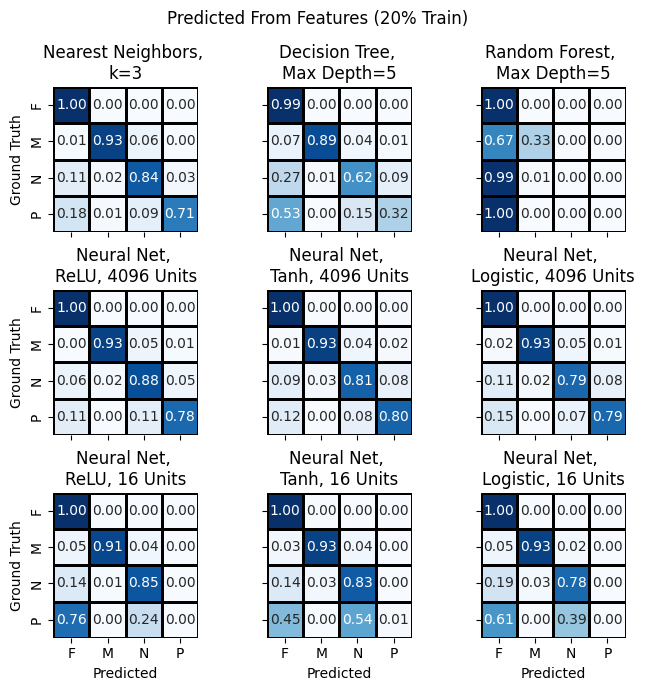

In [ ]:
# ~5 dk, %20 train, %80 test
score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=2, shrink_by=128, suptitle="Predicted From Features (20% Train)")

In [ ]:
score_dict

{'Nearest Neighbors, \nk=3': 0.9849861714737258,
 'Decision Tree, \nMax Depth=5': 0.9644903200316081,
 'Random Forest, \nMax Depth=5': 0.919399446858949,
 'Neural Net, \nReLU, 4096 Units': 0.9864677992888187,
 'Neural Net, \nTanh, 4096 Units': 0.9816278150928487,
 'Neural Net, \nLogistic, 4096 Units': 0.9830106677202687,
 'Neural Net, \nReLU, 16 Units': 0.975898854207823,
 'Neural Net, \nTanh, 16 Units': 0.9755037534571316,
 'Neural Net, \nLogistic, 16 Units': 0.9730837613591465}

In [ ]:
times_dict

{'Nearest Neighbors, \nk=3': {'train_time': 0.008080244064331055,
  'inference_time_per_sample': 0.0008753890201820304},
 'Decision Tree, \nMax Depth=5': {'train_time': 6.606592178344727,
  'inference_time_per_sample': 9.658142588723558e-07},
 'Random Forest, \nMax Depth=5': {'train_time': 0.05442214012145996,
  'inference_time_per_sample': 2.515370174153244e-06},
 'Neural Net, \nReLU, 4096 Units': {'train_time': 71.10838603973389,
  'inference_time_per_sample': 0.0003933508798379947},
 'Neural Net, \nTanh, 4096 Units': {'train_time': 62.62772274017334,
  'inference_time_per_sample': 0.00043456239315983996},
 'Neural Net, \nLogistic, 4096 Units': {'train_time': 93.88201975822449,
  'inference_time_per_sample': 0.0004474351595438125},
 'Neural Net, \nReLU, 16 Units': {'train_time': 1.4737961292266846,
  'inference_time_per_sample': 1.1706990434547886e-05},
 'Neural Net, \nTanh, 16 Units': {'train_time': 2.2509357929229736,
  'inference_time_per_sample': 1.7205795625696442e-05},
 'Neural

In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_feature_ellict_pred_20train.csv", index=False)

### Abblation Tests: 1%, 5%, 10% training partititoning




.....Train Rate = 0.01........



Train set distribution:
 {'full': 234, 'multiple_objects': 5, 'none': 8, 'partial': 6} Total: 253

Test set distribution:
 {'full': 22818, 'multiple_objects': 667, 'none': 1230, 'partial': 341} Total: 25056

Train set distribution (%):
 {'full': 0.924901185770751, 'multiple_objects': 0.019762845849802372, 'none': 0.03162055335968379, 'partial': 0.023715415019762844}

Test set distribution (%):
 {'full': 0.9106800766283525, 'multiple_objects': 0.02662037037037037, 'none': 0.04909003831417624, 'partial': 0.013609514687100893}
Number of features: 2048
Wide units: 4096, Narrow units: 16


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9467991698595147
Time:  {'train_time': 0.0021317005157470703, 'inference_time_per_sample': 6.719290410878558e-05}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.95      1.00      0.97     22818
multiple_objects       0.95      0.93  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       1.00      0.01      0.02       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.48      0.25      0.24     25056
    weighted avg       0.86      0.91      0.87     25056

Random Forest, 
Max Depth=5 confusion matrix:
[[22818     0     0     0]
 [  661     6     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[1.        0.        0.        0.       ]
 [0.9910045 0.0089955 0.        0.       ]
 [1.        0.        0.        0.       ]
 [1.        0.        0.        0.       ]]


Neural Net, 
ReLU, 4096 Units
Iteration 1, loss = 13.39022273
Validation score: 0.923077
Iterat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
ReLU, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
ReLU, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 4096 Units
Iteration 1, loss = 13.27356308
Validation score: 0.923077
Iteration 2, loss = 12.52659948
Validation score: 0.923077
Iteration 3, loss = 11.66370959
Validation score: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Tanh, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 4096 Units
Iteration 1, loss = 5.64307924
Validation score: 0.923077
Iteration 2, loss = 4.70318235
Validation score: 0.923077
Iteration 3, loss = 4.18459721
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Logistic, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Logistic, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 16 Units
Iteration 1, loss = 3.76956060
Validation score: 0.576923
Iteration 2, loss = 1.18260492
Validation score: 1.000000
Iteration 3, loss = 0.57489954
Validation sco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       1.00      0.01      0.02      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.48      0.25      0.24     25056
    weighted avg       0.88      0.91      0.87     25056

Neural Net, 
Tanh, 16 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1196    21    13     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 16 Units normalized confusion matrix:
[[1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.97235772 0.01707317 0.01056911 0.        ]
 [1.         0.         0.         0.        ]]


Neural Net, 
Logistic, 16 Units
Iteration 1, loss = 1.79233103
Validation score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.93      0.98      0.95     22818
multiple_objects       0.05      0.08      0.06       667
            none       1.00      0.01      0.01      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.89     25056
       macro avg       0.49      0.27      0.26     25056
    weighted avg       0.89      0.89      0.87     25056

Neural Net, 
Logistic, 16 Units confusion matrix:
[[22267   551     0     0]
 [  615    52     0     0]
 [  808   414     8     0]
 [  338     3     0     0]]
Neural Net, 
Logistic, 16 Units normalized confusion matrix:
[[0.9758524  0.0241476  0.         0.        ]
 [0.92203898 0.07796102 0.         0.        ]
 [0.65691057 0.33658537 0.00650407 0.        ]
 [0.99120235 0.00879765 0.         0.        ]]


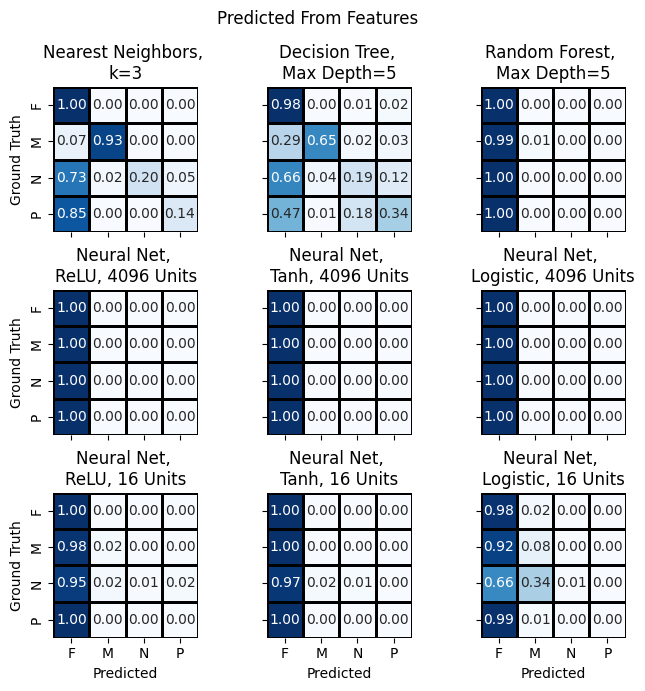

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9467991698595147, 'Decision Tree, \nMax Depth=5': 0.9198196040868455, 'Random Forest, \nMax Depth=5': 0.9109195402298851, 'Neural Net, \nReLU, 4096 Units': 0.9106800766283525, 'Neural Net, \nTanh, 4096 Units': 0.9106800766283525, 'Neural Net, \nLogistic, 4096 Units': 0.9106800766283525, 'Neural Net, \nReLU, 16 Units': 0.911478288633461, 'Neural Net, \nTanh, 16 Units': 0.911198914431673, 'Neural Net, \nLogistic, 16 Units': 0.8910839719029374}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.0021317005157470703, 'inference_time_per_sample': 6.719290410878558e-05}, 'Decision Tree, \nMax Depth=5': {'train_time': 0.2430410385131836, 'inference_time_per_sample': 9.138522476985537e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.019092082977294922, 'inference_time_per_sample': 2.1118542243694436e-06}, 'Neural Net, \nReLU, 4096 Units': {'train_time': 6.504481077194214, 'inference_time_per_sample': 0.00039834859346825807}, 'Neural Ne

In [ ]:
# %1 Train
train_rate = 0.01
print(f".....Train Rate = {train_rate}........\n\n")

# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = features_npy
y = features_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))

score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=2, shrink_by=128, suptitle="Predicted From Features")

print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_feature_ellict_pred_1train.csv", index=False)

.....Train Rate = 0.05........



Train set distribution:
 {'full': 1144, 'multiple_objects': 40, 'none': 61, 'partial': 20} Total: 1265

Test set distribution:
 {'full': 21908, 'multiple_objects': 632, 'none': 1177, 'partial': 327} Total: 24044

Train set distribution (%):
 {'full': 0.9043478260869565, 'multiple_objects': 0.03162055335968379, 'none': 0.048221343873517786, 'partial': 0.015810276679841896}

Test set distribution (%):
 {'full': 0.9111628680751954, 'multiple_objects': 0.026285143902844785, 'none': 0.04895192147729163, 'partial': 0.013600066544668108}
Number of features: 2048
Wide units: 4096, Narrow units: 16


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9755864248877059
Time:  {'train_time': 0.0029647350311279297, 'inference_time_per_sample': 0.00020741937442500944}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.98      1.00      0.99     21908
multiple_objects       0.93    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.92      1.00      0.96     21908
multiple_objects       0.97      0.47      0.64       632
            none       0.80      0.00      0.01      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.92     24044
       macro avg       0.67      0.37      0.40     24044
    weighted avg       0.91      0.92      0.89     24044

Random Forest, 
Max Depth=5 confusion matrix:
[[21907     1     0     0]
 [  333   298     1     0]
 [ 1166     7     4     0]
 [  327     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99954355e-01 4.56454263e-05 0.00000000e+00 0.00000000e+00]
 [5.26898734e-01 4.71518987e-01 1.58227848e-03 0.00000000e+00]
 [9.90654206e-01 5.94732370e-03 3.39847069e-03 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.97      1.00      0.98     21908
multiple_objects       0.97      0.84      0.90       632
            none       0.86      0.62      0.72      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.96     24044
       macro avg       0.70      0.61      0.65     24044
    weighted avg       0.95      0.96      0.95     24044

Neural Net, 
Tanh, 4096 Units confusion matrix:
[[21881     1    26     0]
 [   39   534    59     0]
 [  435    17   725     0]
 [  291     0    36     0]]
Neural Net, 
Tanh, 4096 Units normalized confusion matrix:
[[9.98767573e-01 4.56454263e-05 1.18678108e-03 0.00000000e+00]
 [6.17088608e-02 8.44936709e-01 9.33544304e-02 0.00000000e+00]
 [3.69583687e-01 1.44435004e-02 6.15972812e-01 0.00000000e+00]
 [8.89908257e-01 0.00000000e+00 1.10091743e-01 0.00000000e+00]]


Neural Ne

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.97      1.00      0.98     21908
multiple_objects       0.94      0.93      0.93       632
            none       0.88      0.62      0.73      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.96     24044
       macro avg       0.70      0.64      0.66     24044
    weighted avg       0.95      0.96      0.95     24044

Neural Net, 
Logistic, 4096 Units confusion matrix:
[[21852     1    55     0]
 [   37   588     7     0]
 [  416    36   725     0]
 [  290     2    35     0]]
Neural Net, 
Logistic, 4096 Units normalized confusion matrix:
[[9.97443856e-01 4.56454263e-05 2.51049845e-03 0.00000000e+00]
 [5.85443038e-02 9.30379747e-01 1.10759494e-02 0.00000000e+00]
 [3.53440952e-01 3.05862362e-02 6.15972812e-01 0.00000000e+00]
 [8.86850153e-01 6.11620795e-03 1.07033639e-01 0.00000000e+00]]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.91     24044
       macro avg       0.23      0.25      0.24     24044
    weighted avg       0.83      0.91      0.87     24044

Neural Net, 
Logistic, 16 Units confusion matrix:
[[21908     0     0     0]
 [  632     0     0     0]
 [ 1117    60     0     0]
 [  327     0     0     0]]
Neural Net, 
Logistic, 16 Units normalized confusion matrix:
[[1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.94902294 0.05097706 0.         0.        ]
 [1.         0.         0.         0.        ]]


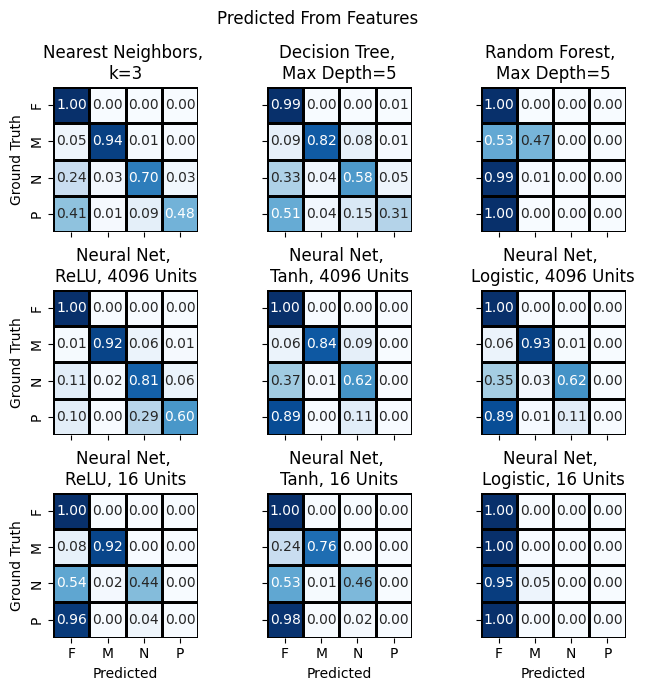

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9755864248877059, 'Decision Tree, \nMax Depth=5': 0.9534187323240725, 'Random Forest, \nMax Depth=5': 0.9236815837631009, 'Neural Net, \nReLU, 4096 Units': 0.9792047912161038, 'Neural Net, \nTanh, 4096 Units': 0.9624022625187156, 'Neural Net, \nLogistic, 4096 Units': 0.9634420229579105, 'Neural Net, \nReLU, 16 Units': 0.9568707369821993, 'Neural Net, \nTanh, 16 Units': 0.9533355514889369, 'Neural Net, \nLogistic, 16 Units': 0.9111628680751954}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.0029647350311279297, 'inference_time_per_sample': 0.00020741937442500944}, 'Decision Tree, \nMax Depth=5': {'train_time': 1.2836551666259766, 'inference_time_per_sample': 9.899666138406086e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.024389266967773438, 'inference_time_per_sample': 2.4867462370166007e-06}, 'Neural Net, \nReLU, 4096 Units': {'train_time': 30.476013660430908, 'inference_time_per_sample': 0.00026350490584029987}, 'Neura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       1.00      0.01      0.02       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.48      0.25      0.24     25056
    weighted avg       0.86      0.91      0.87     25056

Random Forest, 
Max Depth=5 confusion matrix:
[[22818     0     0     0]
 [  661     6     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[1.        0.        0.        0.       ]
 [0.9910045 0.0089955 0.        0.       ]
 [1.        0.        0.        0.       ]
 [1.        0.        0.        0.       ]]


Neural Net, 
ReLU, 4096 Units
Iteration 1, loss = 13.39022273
Validation score: 0.923077
Iterat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
ReLU, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
ReLU, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 4096 Units
Iteration 1, loss = 13.27356308
Validation score: 0.923077
Iteration 2, loss = 12.52659948
Validation score: 0.923077
Iteration 3, loss = 11.66370959
Validation score: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Tanh, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 4096 Units
Iteration 1, loss = 5.64307924
Validation score: 0.923077
Iteration 2, loss = 4.70318235
Validation score: 0.923077
Iteration 3, loss = 4.18459721
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Logistic, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Logistic, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 16 Units
Iteration 1, loss = 3.76956060
Validation score: 0.576923
Iteration 2, loss = 1.18260492
Validation score: 1.000000
Iteration 3, loss = 0.57489954
Validation sco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       1.00      0.01      0.02      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.48      0.25      0.24     25056
    weighted avg       0.88      0.91      0.87     25056

Neural Net, 
Tanh, 16 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1196    21    13     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 16 Units normalized confusion matrix:
[[1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.97235772 0.01707317 0.01056911 0.        ]
 [1.         0.         0.         0.        ]]


Neural Net, 
Logistic, 16 Units
Iteration 1, loss = 1.79233103
Validation score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.93      0.98      0.95     22818
multiple_objects       0.05      0.08      0.06       667
            none       1.00      0.01      0.01      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.89     25056
       macro avg       0.49      0.27      0.26     25056
    weighted avg       0.89      0.89      0.87     25056

Neural Net, 
Logistic, 16 Units confusion matrix:
[[22267   551     0     0]
 [  615    52     0     0]
 [  808   414     8     0]
 [  338     3     0     0]]
Neural Net, 
Logistic, 16 Units normalized confusion matrix:
[[0.9758524  0.0241476  0.         0.        ]
 [0.92203898 0.07796102 0.         0.        ]
 [0.65691057 0.33658537 0.00650407 0.        ]
 [0.99120235 0.00879765 0.         0.        ]]


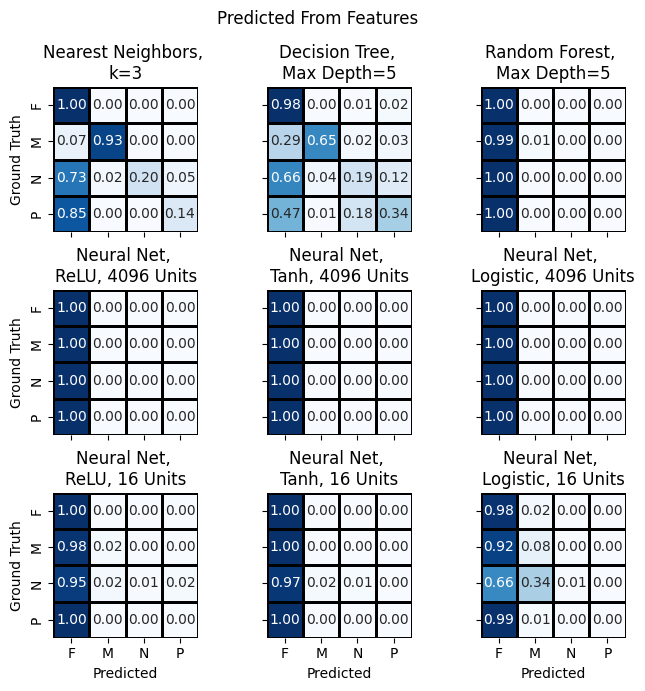

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9467991698595147, 'Decision Tree, \nMax Depth=5': 0.9198196040868455, 'Random Forest, \nMax Depth=5': 0.9109195402298851, 'Neural Net, \nReLU, 4096 Units': 0.9106800766283525, 'Neural Net, \nTanh, 4096 Units': 0.9106800766283525, 'Neural Net, \nLogistic, 4096 Units': 0.9106800766283525, 'Neural Net, \nReLU, 16 Units': 0.911478288633461, 'Neural Net, \nTanh, 16 Units': 0.911198914431673, 'Neural Net, \nLogistic, 16 Units': 0.8910839719029374}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.0021910667419433594, 'inference_time_per_sample': 4.659208682000561e-05}, 'Decision Tree, \nMax Depth=5': {'train_time': 0.24072909355163574, 'inference_time_per_sample': 9.571569632753102e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.017442703247070312, 'inference_time_per_sample': 2.3035710798826253e-06}, 'Neural Net, \nReLU, 4096 Units': {'train_time': 4.59834623336792, 'inference_time_per_sample': 0.00027141421272075647}, 'Neural Ne

In [ ]:
# %5 Train
train_rate = 0.05
print(f".....Train Rate = {train_rate}........\n\n")

# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = features_npy
y = features_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))

score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=2, shrink_by=128, suptitle="Predicted From Features")

print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)# %1 Train
pred_df.to_csv(savepath+"resnet50_classification_feature_ellict_pred_5train.csv", index=False)

.....Train Rate = 0.1........



Train set distribution:
 {'full': 2287, 'multiple_objects': 75, 'none': 133, 'partial': 35} Total: 2530

Test set distribution:
 {'full': 20765, 'multiple_objects': 597, 'none': 1105, 'partial': 312} Total: 22779

Train set distribution (%):
 {'full': 0.9039525691699605, 'multiple_objects': 0.029644268774703556, 'none': 0.05256916996047431, 'partial': 0.01383399209486166}

Test set distribution (%):
 {'full': 0.9115852320119409, 'multiple_objects': 0.026208349795864613, 'none': 0.04850959216822512, 'partial': 0.013696826023969445}
Number of features: 2048
Wide units: 4096, Narrow units: 16


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9801132622151982
Time:  {'train_time': 0.005532026290893555, 'inference_time_per_sample': 0.00044651391335694227}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.99      1.00      0.99     20765
multiple_objects       0.92      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.92      1.00      0.96     20765
multiple_objects       0.98      0.22      0.35       597
            none       1.00      0.01      0.02      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.92     22779
       macro avg       0.73      0.31      0.33     22779
    weighted avg       0.91      0.92      0.88     22779

Random Forest, 
Max Depth=5 confusion matrix:
[[20764     1     0     0]
 [  468   129     0     0]
 [ 1094     1    10     0]
 [  312     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99951842e-01 4.81579581e-05 0.00000000e+00 0.00000000e+00]
 [7.83919598e-01 2.16080402e-01 0.00000000e+00 0.00000000e+00]
 [9.90045249e-01 9.04977376e-04 9.04977376e-03 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.96      1.00      0.98     20765
multiple_objects       0.96      0.92      0.94       597
            none       0.91      0.57      0.70      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.96     22779
       macro avg       0.71      0.62      0.65     22779
    weighted avg       0.95      0.96      0.95     22779

Neural Net, 
ReLU, 16 Units confusion matrix:
[[20749     1    15     0]
 [   41   550     6     0]
 [  454    23   628     0]
 [  268     0    44     0]]
Neural Net, 
ReLU, 16 Units normalized confusion matrix:
[[9.99229473e-01 4.81579581e-05 7.22369372e-04 0.00000000e+00]
 [6.86767169e-02 9.21273032e-01 1.00502513e-02 0.00000000e+00]
 [4.10859729e-01 2.08144796e-02 5.68325792e-01 0.00000000e+00]
 [8.58974359e-01 0.00000000e+00 1.41025641e-01 0.00000000e+00]]


Neural Net, 
Ta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.96      1.00      0.98     20765
multiple_objects       0.97      0.91      0.94       597
            none       0.93      0.58      0.71      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.96     22779
       macro avg       0.72      0.62      0.66     22779
    weighted avg       0.95      0.96      0.95     22779

Neural Net, 
Tanh, 16 Units confusion matrix:
[[20748     1    16     0]
 [   53   542     2     0]
 [  451    17   637     0]
 [  285     0    27     0]]
Neural Net, 
Tanh, 16 Units normalized confusion matrix:
[[9.99181315e-01 4.81579581e-05 7.70527330e-04 0.00000000e+00]
 [8.87772194e-02 9.07872697e-01 3.35008375e-03 0.00000000e+00]
 [4.08144796e-01 1.53846154e-02 5.76470588e-01 0.00000000e+00]
 [9.13461538e-01 0.00000000e+00 8.65384615e-02 0.00000000e+00]]


Neural Net, 
Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.97      1.00      0.98     20765
multiple_objects       0.95      0.92      0.94       597
            none       0.93      0.60      0.73      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.96     22779
       macro avg       0.71      0.63      0.66     22779
    weighted avg       0.95      0.96      0.96     22779

Neural Net, 
Logistic, 16 Units confusion matrix:
[[20748     1    16     0]
 [   39   552     6     0]
 [  418    26   661     0]
 [  284     0    28     0]]
Neural Net, 
Logistic, 16 Units normalized confusion matrix:
[[9.99181315e-01 4.81579581e-05 7.70527330e-04 0.00000000e+00]
 [6.53266332e-02 9.24623116e-01 1.00502513e-02 0.00000000e+00]
 [3.78280543e-01 2.35294118e-02 5.98190045e-01 0.00000000e+00]
 [9.10256410e-01 0.00000000e+00 8.97435897e-02 0.00000000e+00]]


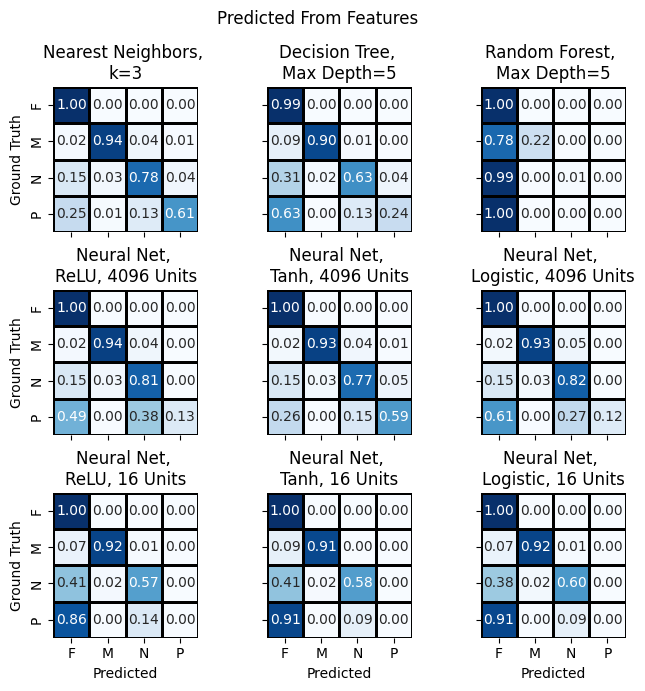

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9801132622151982, 'Decision Tree, \nMax Depth=5': 0.9628605294350059, 'Random Forest, \nMax Depth=5': 0.9176434435225427, 'Neural Net, \nReLU, 4096 Units': 0.9764695552921551, 'Neural Net, \nTanh, 4096 Units': 0.980332762632249, 'Neural Net, \nLogistic, 4096 Units': 0.9766890557092058, 'Neural Net, \nReLU, 16 Units': 0.962597128934545, 'Neural Net, \nTanh, 16 Units': 0.962597128934545, 'Neural Net, \nLogistic, 16 Units': 0.9640897317704904}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.005532026290893555, 'inference_time_per_sample': 0.00044651391335694227}, 'Decision Tree, \nMax Depth=5': {'train_time': 2.6646580696105957, 'inference_time_per_sample': 9.28575420375452e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.03308701515197754, 'inference_time_per_sample': 2.3545025261518456e-06}, 'Neural Net, \nReLU, 4096 Units': {'train_time': 25.737711906433105, 'inference_time_per_sample': 0.0002957385021430604}, 'Neural Net, 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       1.00      0.01      0.02       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.48      0.25      0.24     25056
    weighted avg       0.86      0.91      0.87     25056

Random Forest, 
Max Depth=5 confusion matrix:
[[22818     0     0     0]
 [  661     6     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[1.        0.        0.        0.       ]
 [0.9910045 0.0089955 0.        0.       ]
 [1.        0.        0.        0.       ]
 [1.        0.        0.        0.       ]]


Neural Net, 
ReLU, 4096 Units
Iteration 1, loss = 13.39022273
Validation score: 0.923077
Iterat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
ReLU, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
ReLU, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 4096 Units
Iteration 1, loss = 13.27356308
Validation score: 0.923077
Iteration 2, loss = 12.52659948
Validation score: 0.923077
Iteration 3, loss = 11.66370959
Validation score: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Tanh, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 4096 Units
Iteration 1, loss = 5.64307924
Validation score: 0.923077
Iteration 2, loss = 4.70318235
Validation score: 0.923077
Iteration 3, loss = 4.18459721
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4096 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Logistic, 4096 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Logistic, 4096 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 16 Units
Iteration 1, loss = 3.76956060
Validation score: 0.576923
Iteration 2, loss = 1.18260492
Validation score: 1.000000
Iteration 3, loss = 0.57489954
Validation sco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       1.00      0.01      0.02      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.48      0.25      0.24     25056
    weighted avg       0.88      0.91      0.87     25056

Neural Net, 
Tanh, 16 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1196    21    13     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 16 Units normalized confusion matrix:
[[1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.97235772 0.01707317 0.01056911 0.        ]
 [1.         0.         0.         0.        ]]


Neural Net, 
Logistic, 16 Units
Iteration 1, loss = 1.79233103
Validation score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 16 Units classification report:
                  precision    recall  f1-score   support

            full       0.93      0.98      0.95     22818
multiple_objects       0.05      0.08      0.06       667
            none       1.00      0.01      0.01      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.89     25056
       macro avg       0.49      0.27      0.26     25056
    weighted avg       0.89      0.89      0.87     25056

Neural Net, 
Logistic, 16 Units confusion matrix:
[[22267   551     0     0]
 [  615    52     0     0]
 [  808   414     8     0]
 [  338     3     0     0]]
Neural Net, 
Logistic, 16 Units normalized confusion matrix:
[[0.9758524  0.0241476  0.         0.        ]
 [0.92203898 0.07796102 0.         0.        ]
 [0.65691057 0.33658537 0.00650407 0.        ]
 [0.99120235 0.00879765 0.         0.        ]]


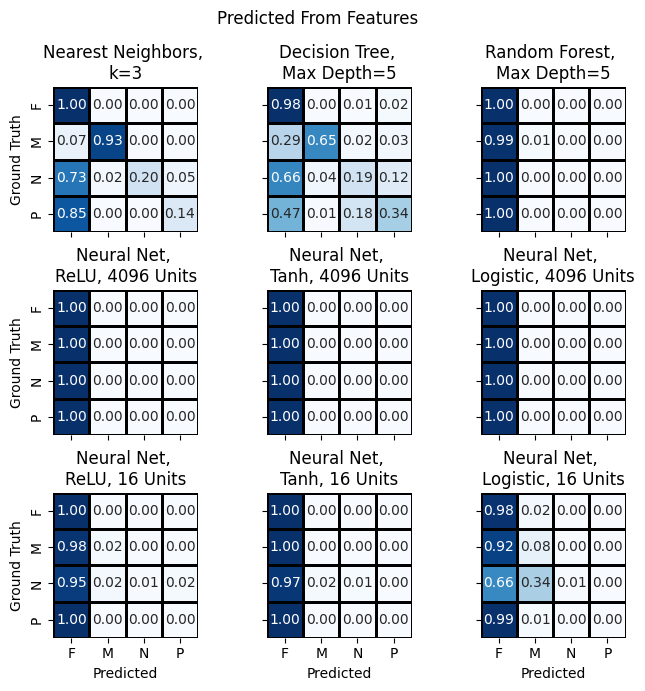

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9467991698595147, 'Decision Tree, \nMax Depth=5': 0.9198196040868455, 'Random Forest, \nMax Depth=5': 0.9109195402298851, 'Neural Net, \nReLU, 4096 Units': 0.9106800766283525, 'Neural Net, \nTanh, 4096 Units': 0.9106800766283525, 'Neural Net, \nLogistic, 4096 Units': 0.9106800766283525, 'Neural Net, \nReLU, 16 Units': 0.911478288633461, 'Neural Net, \nTanh, 16 Units': 0.911198914431673, 'Neural Net, \nLogistic, 16 Units': 0.8910839719029374}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.0014255046844482422, 'inference_time_per_sample': 6.162384727144302e-05}, 'Decision Tree, \nMax Depth=5': {'train_time': 0.23329806327819824, 'inference_time_per_sample': 9.224446797279562e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.023237943649291992, 'inference_time_per_sample': 2.1354620027359418e-06}, 'Neural Net, \nReLU, 4096 Units': {'train_time': 3.7719783782958984, 'inference_time_per_sample': 0.00026269407412405976}, 'Neural 

In [ ]:
# %10 Train
train_rate = 0.1
print(f".....Train Rate = {train_rate}........\n\n")

# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = features_npy
y = features_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))

score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=2, shrink_by=128, suptitle="Predicted From Features")

print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_feature_ellict_pred_10train.csv", index=False)

## 3.2.From Logits

In [ ]:
import pandas as pd
import numpy as np

logits_df = pd.read_csv(savepath+"resnet50_logits.csv")
logits_df['features'] = logits_df['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
logits_df['features'][0]

array([1.6247515e-02, 2.2942699e-04, 9.8259549e-04, 2.7647600e-05,
       8.6401147e-04, 9.8140299e-01, 1.4646196e-04, 9.9330478e-05])

In [ ]:
# Prepare dataset
logits_df['bbox_coverage'] = logits_df['bbox_coverage'].apply(lambda x: "full" if "full" in x else x)
print(logits_df.head())
class_names = logits_df["bbox_coverage"].unique().tolist()
print(class_names)

                                            img_path          class_name  \
0  cropped_dials_students_abc/1_1_airspeed_indica...  airspeed_indicator   
1       cropped_dials_students_abc/1_1_dashboard.png           dashboard   
2       cropped_dials_students_abc/1_1_altimeter.png           altimeter   
3  cropped_dials_students_abc/1_1_attitude_indica...  attitude_indicator   
4       cropped_dials_students_abc/2_1_dashboard.png           dashboard   

  bbox_coverage                                           features  
0          full  [0.016247515, 0.00022942699, 0.00098259549, 2....  
1          full  [1.3967739e-08, 2.6313879e-05, 5.0882758e-05, ...  
2          full  [0.027519492, 0.45054847, 1.5530342e-06, 4.208...  
3          full  [0.00095743185, 0.85864615, 0.0053806542, 3.80...  
4          full  [1.2241784e-07, 1.9656436e-05, 6.0044008e-06, ...  
['full', 'none', 'partial', 'multiple_objects']


In [ ]:
logits = logits_df['features'].apply(lambda x: np.array(x)).tolist()
logits = np.array(logits)
logits.shape

(25309, 8)

### Typical Partition: %80 train, %20 test

In [ ]:
# PREDICT FROM LOGITS
X = logits
y = logits_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
train_rate = 0.8
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]

# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))


Train set distribution:
 {'full': 18434, 'multiple_objects': 553, 'none': 977, 'partial': 283} Total: 20247

Test set distribution:
 {'full': 4618, 'multiple_objects': 119, 'none': 261, 'partial': 64} Total: 5062

Train set distribution (%):
 {'full': 0.9104558700054329, 'multiple_objects': 0.02731268829950116, 'none': 0.04825406233022176, 'partial': 0.013977379364844174}

Test set distribution (%):
 {'full': 0.9122876333465033, 'multiple_objects': 0.023508494666139867, 'none': 0.05156064796523113, 'partial': 0.012643224022125641}


Number of features: 8
Wide units: 1024, Narrow units: 4


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9557487159225603
Time:  {'train_time': 0.055816650390625, 'inference_time_per_sample': 0.00010410103106489298}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.97      0.99      0.98      4618
multiple_objects       0.75      0.87      0.80       119
            none       0.82      0.57      0.67       261
         partial       0.25      0.08      0.12        64

        accuracy                           0.96      5062
       macro avg       0.70      0.63      0.64      5062
    weighted avg       0.95      0.96      0.95      5062

Nearest Neighbors, 
k=3 confusion matrix:
[[4581    8   20    9]
 [   6  103    9    1]
 [  81   26  149    5]
 [  54    1    4    5]]
Nearest Neighbors, 
k=3 normalized confusion matrix:
[[0.99198787 0.00173235 0.00433088 0.0019489 ]
 [0.05042017 0.86554622 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Random Forest, 
Max Depth=5
Random Forest, 
Max Depth=5 score: 0.9375740813907546
Time:  {'train_time': 0.23999238014221191, 'inference_time_per_sample': 1.5879186044705804e-06}
Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.94      1.00      0.97      4618
multiple_objects       0.96      0.45      0.62       119
            none       1.00      0.28      0.44       261
         partial       0.00      0.00      0.00        64

        accuracy                           0.94      5062
       macro avg       0.73      0.43      0.51      5062
    weighted avg       0.93      0.94      0.92      5062

Random Forest, 
Max Depth=5 confusion matrix:
[[4618    0    0    0]
 [  65   54    0    0]
 [ 185    2   74    0]
 [  64    0    0    0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[1.         0.         0.         0.        ]
 [0.54621849 0.45378151 0.         0.        ]
 [0.70881226

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Neural Net, 
ReLU, 1024 Units
Iteration 1, loss = 0.54496181
Validation score: 0.923951
Iteration 2, loss = 0.36115825
Validation score: 0.928395
Iteration 3, loss = 0.34923508
Validation score: 0.929383
Iteration 4, loss = 0.34359344
Validation score: 0.928889
Iteration 5, loss = 0.34038218
Validation score: 0.929877
Iteration 6, loss = 0.33848733
Validation score: 0.929383
Iteration 7, loss = 0.33705776
Validation score: 0.929877
Iteration 8, loss = 0.33602549
Validation score: 0.929877
Iteration 9, loss = 0.33555010
Validation score: 0.929877
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
Neural Net, 
ReLU, 1024 Units score: 0.9190043461082577
Time:  {'train_time': 8.590686082839966, 'inference_time_per_sample': 9.462655367751406e-06}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.92      1.00      0.96      4618
multiple_objects       0.00      0.00      0.00       119
            none       0.63      0.15      0.24       261
         partial       0.00      0.00      0.00        64

        accuracy                           0.92      5062
       macro avg       0.39      0.29      0.30      5062
    weighted avg       0.87      0.92      0.89      5062

Neural Net, 
ReLU, 1024 Units confusion matrix:
[[4613    0    5    0]
 [ 103    0   16    0]
 [ 222    0   39    0]
 [  62    0    2    0]]
Neural Net, 
ReLU, 1024 Units normalized confusion matrix:
[[0.99891728 0.         0.00108272 0.        ]
 [0.86554622 0.         0.13445378 0.        ]
 [0.85057471 0.         0.14942529 0.        ]
 [0.96875    0.         0.03125    0.        ]]


Neural Net, 
Tanh, 1024 Units
Iteration 1, loss = 0.49254585
Validation score: 0.928395
I

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Neural Net, 
Logistic, 1024 Units
Iteration 1, loss = 0.44972950
Validation score: 0.923951
Iteration 2, loss = 0.39882876
Validation score: 0.923951
Iteration 3, loss = 0.40048129
Validation score: 0.923951
Iteration 4, loss = 0.40072948
Validation score: 0.923951
Iteration 5, loss = 0.39839198
Validation score: 0.923951
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
Neural Net, 
Logistic, 1024 Units score: 0.9122876333465033
Time:  {'train_time': 4.316838502883911, 'inference_time_per_sample': 2.6850491255839697e-05}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95      4618
multiple_objects       0.00      0.00      0.00       119
            none       0.00      0.00      0.00       261
         partial       0.00      0.00      0.00        64

        accuracy                           0.91      5062
       macro avg       0.23      0.25      0.24      5062
    weighted avg       0.83      0.91      0.87      5062

Neural Net, 
Logistic, 1024 Units confusion matrix:
[[4618    0    0    0]
 [ 119    0    0    0]
 [ 261    0    0    0]
 [  64    0    0    0]]
Neural Net, 
Logistic, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 0 Units
Iteration 1, loss = 1.52967681
Validation score: 0.362963
Iteration 2, loss = 1.23894834
Validation score: 0.631605
Iteration 3, loss = 1.03287110
Validation score: 0.880494
Iter

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 0 Units confusion matrix:
[[4618    0    0    0]
 [ 119    0    0    0]
 [ 261    0    0    0]
 [  64    0    0    0]]
Neural Net, 
ReLU, 0 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 0 Units
Iteration 1, loss = 1.40820545
Validation score: 0.574815
Iteration 2, loss = 1.03974082
Validation score: 0.893827
Iteration 3, loss = 0.78421554
Validation score: 0.917531
Iteration 4, loss = 0.62823377
Validation score: 0.917531
Iteration 5, loss = 0.53994559
Validation score: 0.917531
Iteration 6, loss = 0.49080534
Validation score: 0.917531
Iteration 7, loss = 0.46199236
Validation score: 0.917531
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
Neural Net, 
Tanh, 0 Units score: 0.9122876333465033
Time:  {'train_time': 0.36739110946655273, 'inference_time_per_sample': 6.628337936974099e-07}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 0 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95      4618
multiple_objects       0.00      0.00      0.00       119
            none       0.00      0.00      0.00       261
         partial       0.00      0.00      0.00        64

        accuracy                           0.91      5062
       macro avg       0.23      0.25      0.24      5062
    weighted avg       0.83      0.91      0.87      5062

Neural Net, 
Tanh, 0 Units confusion matrix:
[[4618    0    0    0]
 [ 119    0    0    0]
 [ 261    0    0    0]
 [  64    0    0    0]]
Neural Net, 
Tanh, 0 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 0 Units
Iteration 1, loss = 1.45808480
Validation score: 0.014815
Iteration 2, loss = 1.12654168
Validation score: 0.917531
Iteration 3, loss = 0.86761386
Validation score: 0.917531
Iteration 4, loss = 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


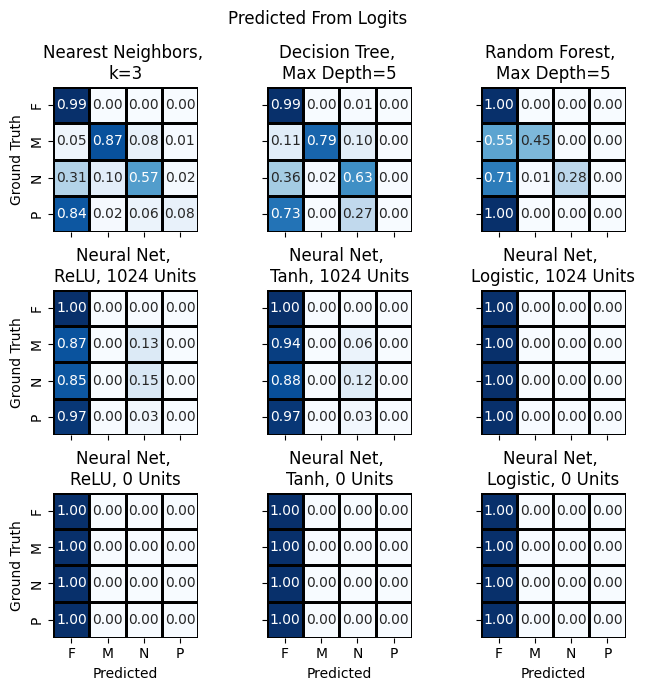

In [ ]:
score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=128, shrink_by=2, suptitle="Predicted From Logits")

In [ ]:
score_dict

{'Nearest Neighbors, \nk=3': 0.9557487159225603,
 'Decision Tree, \nMax Depth=5': 0.9563413670485974,
 'Random Forest, \nMax Depth=5': 0.9375740813907546,
 'Neural Net, \nReLU, 1024 Units': 0.9190043461082577,
 'Neural Net, \nTanh, 1024 Units': 0.9178190438561833,
 'Neural Net, \nLogistic, 1024 Units': 0.9122876333465033,
 'Neural Net, \nReLU, 0 Units': 0.9122876333465033,
 'Neural Net, \nTanh, 0 Units': 0.9122876333465033,
 'Neural Net, \nLogistic, 0 Units': 0.9122876333465033}

In [ ]:
times_dict

{'Nearest Neighbors, \nk=3': {'train_time': 0.055816650390625,
  'inference_time_per_sample': 0.00010410103106489298},
 'Decision Tree, \nMax Depth=5': {'train_time': 0.20441365242004395,
  'inference_time_per_sample': 1.651785770267048e-07},
 'Random Forest, \nMax Depth=5': {'train_time': 0.23999238014221191,
  'inference_time_per_sample': 1.5879186044705804e-06},
 'Neural Net, \nReLU, 1024 Units': {'train_time': 8.590686082839966,
  'inference_time_per_sample': 9.462655367751406e-06},
 'Neural Net, \nTanh, 1024 Units': {'train_time': 20.004242420196533,
  'inference_time_per_sample': 6.917821988904962e-05},
 'Neural Net, \nLogistic, 1024 Units': {'train_time': 4.316838502883911,
  'inference_time_per_sample': 2.6850491255839697e-05},
 'Neural Net, \nReLU, 0 Units': {'train_time': 0.35683417320251465,
  'inference_time_per_sample': 3.812719079073782e-07},
 'Neural Net, \nTanh, 0 Units': {'train_time': 0.36739110946655273,
  'inference_time_per_sample': 6.628337936974099e-07},
 'Neural

In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_logit_ellict_pred.csv", index=False)

### Alternate Partition: %20 train, %80 test

In [ ]:
# PREDICT FROM LOGITS
X = logits
y = logits_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
train_rate = 0.2
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]

# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))


Train set distribution:
 {'full': 4608, 'multiple_objects': 144, 'none': 238, 'partial': 71} Total: 5061

Test set distribution:
 {'full': 18444, 'multiple_objects': 528, 'none': 1000, 'partial': 276} Total: 20248

Train set distribution (%):
 {'full': 0.9104919976289271, 'multiple_objects': 0.02845287492590397, 'none': 0.04702627939142462, 'partial': 0.01402884805374432}

Test set distribution (%):
 {'full': 0.9109047807190833, 'multiple_objects': 0.026076649545634135, 'none': 0.04938759383642829, 'partial': 0.013630975898854208}


Number of features: 8
Wide units: 1024, Narrow units: 4


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.952834847886211
Time:  {'train_time': 0.013259649276733398, 'inference_time_per_sample': 0.00017795696742729631}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.97      0.99      0.98     18444
multiple_objects       0.75      0.83      0.79       528
            none       0.77      0.54      0.63      1000
         partial       0.19      0.03      0.06       276

        accuracy                           0.95     20248
       macro avg       0.67      0.60      0.61     20248
    weighted avg       0.94      0.95      0.95     20248

Nearest Neighbors, 
k=3 confusion matrix:
[[18310    34    79    21]
 [   37   439    52     0]
 [  344   103   535    18]
 [  227     7    33     9]]
Nearest Neighbors, 
k=3 normalized confusion matrix:
[[0.99273476 0.00184342 0.00428324 0.00113858]
 [0.070

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.93      1.00      0.97     18444
multiple_objects       0.99      0.50      0.67       528
            none       0.98      0.25      0.39      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.94     20248
       macro avg       0.73      0.44      0.51     20248
    weighted avg       0.93      0.94      0.92     20248

Random Forest, 
Max Depth=5 confusion matrix:
[[18442     2     0     0]
 [  260   266     2     0]
 [  754     0   246     0]
 [  274     0     2     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99891564e-01 1.08436348e-04 0.00000000e+00 0.00000000e+00]
 [4.92424242e-01 5.03787879e-01 3.78787879e-03 0.00000000e+00]
 [7.54000000e-01 0.00000000e+00 2.46000000e-01 0.00000000e+00]
 [9.92753623e-01 0.00000000e+00 7.24637681e-03 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.92      1.00      0.96     18444
multiple_objects       0.00      0.00      0.00       528
            none       0.68      0.13      0.22      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.92     20248
       macro avg       0.40      0.28      0.29     20248
    weighted avg       0.87      0.92      0.88     20248

Neural Net, 
ReLU, 1024 Units confusion matrix:
[[18428     0    16     0]
 [  498     0    30     0]
 [  869     0   131     0]
 [  260     0    16     0]]
Neural Net, 
ReLU, 1024 Units normalized confusion matrix:
[[9.99132509e-01 0.00000000e+00 8.67490783e-04 0.00000000e+00]
 [9.43181818e-01 0.00000000e+00 5.68181818e-02 0.00000000e+00]
 [8.69000000e-01 0.00000000e+00 1.31000000e-01 0.00000000e+00]
 [9.42028986e-01 0.00000000e+00 5.79710145e-02 0.00000000e+00]]


Neural Ne

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.92      1.00      0.96     18444
multiple_objects       0.00      0.00      0.00       528
            none       0.65      0.14      0.23      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.92     20248
       macro avg       0.39      0.28      0.30     20248
    weighted avg       0.87      0.92      0.88     20248

Neural Net, 
Tanh, 1024 Units confusion matrix:
[[18420     0    24     0]
 [  498     0    30     0]
 [  864     0   136     0]
 [  258     0    18     0]]
Neural Net, 
Tanh, 1024 Units normalized confusion matrix:
[[0.99869876 0.         0.00130124 0.        ]
 [0.94318182 0.         0.05681818 0.        ]
 [0.864      0.         0.136      0.        ]
 [0.93478261 0.         0.06521739 0.        ]]


Neural Net, 
Logistic, 1024 Units
Iteration 1, loss = 0.59643773
Validati

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     18444
multiple_objects       0.00      0.00      0.00       528
            none       0.00      0.00      0.00      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.91     20248
       macro avg       0.23      0.25      0.24     20248
    weighted avg       0.83      0.91      0.87     20248

Neural Net, 
Logistic, 1024 Units confusion matrix:
[[18444     0     0     0]
 [  528     0     0     0]
 [ 1000     0     0     0]
 [  276     0     0     0]]
Neural Net, 
Logistic, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 0 Units
Iteration 1, loss = 1.67900217
Validation score: 0.011834
Iteration 2, loss = 1.56764436
Validation score: 0.011834
Iteration 3, loss = 1.47288027
Validation scor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 0 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     18444
multiple_objects       0.00      0.00      0.00       528
            none       0.00      0.00      0.00      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.91     20248
       macro avg       0.23      0.25      0.24     20248
    weighted avg       0.83      0.91      0.87     20248

Neural Net, 
ReLU, 0 Units confusion matrix:
[[18444     0     0     0]
 [  528     0     0     0]
 [ 1000     0     0     0]
 [  276     0     0     0]]
Neural Net, 
ReLU, 0 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 0 Units
Iteration 1, loss = 1.56801801
Validation score: 0.009862
Iteration 2, loss = 1.45365041
Validation score: 0.193294
Iteration 3, loss = 1.34789251
Validation score: 0.406312
Iteration

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 0 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     18444
multiple_objects       0.00      0.00      0.00       528
            none       0.00      0.00      0.00      1000
         partial       0.00      0.00      0.00       276

        accuracy                           0.91     20248
       macro avg       0.23      0.25      0.24     20248
    weighted avg       0.83      0.91      0.87     20248

Neural Net, 
Tanh, 0 Units confusion matrix:
[[18444     0     0     0]
 [  528     0     0     0]
 [ 1000     0     0     0]
 [  276     0     0     0]]
Neural Net, 
Tanh, 0 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 0 Units
Iteration 1, loss = 1.60150898
Validation score: 0.011834
Iteration 2, loss = 1.49896752
Validation score: 0.011834
Iteration 3, loss = 1.40476760
Validation score: 0.011834
Itera

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 0 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     18444
multiple_objects       0.00      0.00      0.00       528
            none       0.00      0.00      0.00      1000
         partial       0.01      1.00      0.03       276

        accuracy                           0.01     20248
       macro avg       0.00      0.25      0.01     20248
    weighted avg       0.00      0.01      0.00     20248

Neural Net, 
Logistic, 0 Units confusion matrix:
[[    0     0     0 18444]
 [    0     0     0   528]
 [    0     0     0  1000]
 [    0     0     0   276]]
Neural Net, 
Logistic, 0 Units normalized confusion matrix:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


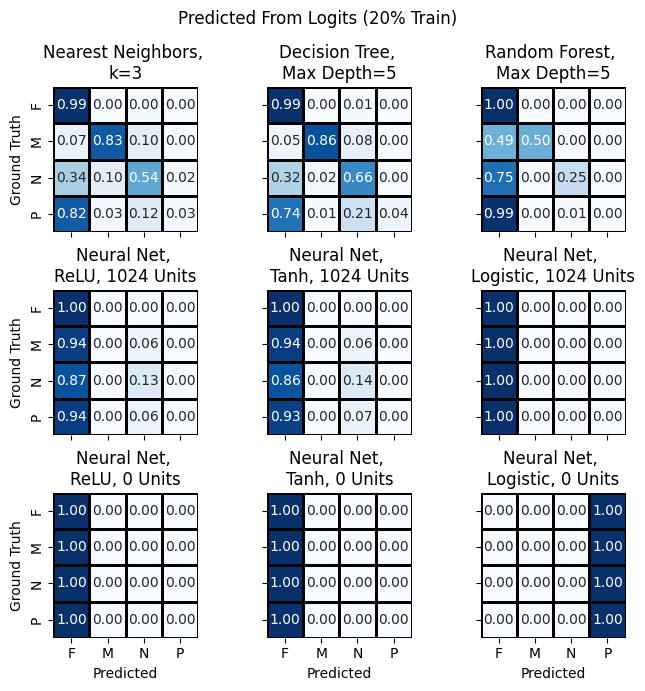

In [ ]:
score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=128, shrink_by=2, suptitle="Predicted From Logits (20% Train)")

In [ ]:
score_dict

{'Nearest Neighbors, \nk=3': 0.952834847886211,
 'Decision Tree, \nMax Depth=5': 0.9571809561438167,
 'Random Forest, \nMax Depth=5': 0.9360924535756618,
 'Neural Net, \nReLU, 1024 Units': 0.9165843540102726,
 'Neural Net, \nTanh, 1024 Units': 0.9164361912287633,
 'Neural Net, \nLogistic, 1024 Units': 0.9109047807190833,
 'Neural Net, \nReLU, 0 Units': 0.9109047807190833,
 'Neural Net, \nTanh, 0 Units': 0.9109047807190833,
 'Neural Net, \nLogistic, 0 Units': 0.013630975898854208}

In [ ]:
times_dict

{'Nearest Neighbors, \nk=3': {'train_time': 0.013259649276733398,
  'inference_time_per_sample': 0.00017795696742729631},
 'Decision Tree, \nMax Depth=5': {'train_time': 0.05099344253540039,
  'inference_time_per_sample': 1.3164360501558025e-07},
 'Random Forest, \nMax Depth=5': {'train_time': 0.0813133716583252,
  'inference_time_per_sample': 1.1710746634011211e-06},
 'Neural Net, \nReLU, 1024 Units': {'train_time': 3.604022979736328,
  'inference_time_per_sample': 9.050957066699102e-06},
 'Neural Net, \nTanh, 1024 Units': {'train_time': 6.484002113342285,
  'inference_time_per_sample': 7.736136535560129e-05},
 'Neural Net, \nLogistic, 1024 Units': {'train_time': 2.108428716659546,
  'inference_time_per_sample': 3.254646748151293e-05},
 'Neural Net, \nReLU, 0 Units': {'train_time': 0.38079404830932617,
  'inference_time_per_sample': 6.535433818586538e-07},
 'Neural Net, \nTanh, 0 Units': {'train_time': 0.32793331146240234,
  'inference_time_per_sample': 1.1059122564104036e-06},
 'Neur

In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_logit_ellict_pred_20train.csv", index=False)

### Abblation Tests: 1%, 5%, 10% training partititoning




.....Train Rate = 0.01........



Train set distribution:
 {'full': 234, 'multiple_objects': 5, 'none': 8, 'partial': 6} Total: 253

Test set distribution:
 {'full': 22818, 'multiple_objects': 667, 'none': 1230, 'partial': 341} Total: 25056

Train set distribution (%):
 {'full': 0.924901185770751, 'multiple_objects': 0.019762845849802372, 'none': 0.03162055335968379, 'partial': 0.023715415019762844}

Test set distribution (%):
 {'full': 0.9106800766283525, 'multiple_objects': 0.02662037037037037, 'none': 0.04909003831417624, 'partial': 0.013609514687100893}
Number of features: 8
Wide units: 1024, Narrow units: 4


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9177043422733078
Time:  {'train_time': 0.0020029544830322266, 'inference_time_per_sample': 0.00011380213773113557}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.93      0.99      0.96     22818
multiple_objects       0.63      0.53      0.57       667
            none       0.17      0.03      0.05      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.92     25056
       macro avg       0.43      0.39      0.40     25056
    weighted avg       0.87      0.92      0.89     25056

Nearest Neighbors, 
k=3 confusion matrix:
[[22606    41   171     0]
 [  306   352     9     0]
 [ 1036   158    36     0]
 [  334     7     0     0]]
Nearest Neighbors, 
k=3 normalized confusion matrix:
[[0.99070909 0.00179683 0.00749408 0.        ]
 [0.45877061 0.52773613 0.01349325 0.        ]
 [0.84227642 0.12845528 0.02926829 0.        ]
 [0.97947214 0.02052786 0.         0.        ]]


Decision Tree, 
Max Depth=5
Decision Tree, 
Max Depth=5 score: 0.9209770114942529
Time:  {'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.96     22818
multiple_objects       1.00      0.15      0.27       667
            none       0.73      0.01      0.02      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.92     25056
       macro avg       0.66      0.29      0.31     25056
    weighted avg       0.90      0.92      0.88     25056

Random Forest, 
Max Depth=5 confusion matrix:
[[22814     0     4     0]
 [  564   103     0     0]
 [ 1219     0    11     0]
 [  341     0     0     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99824700e-01 0.00000000e+00 1.75300202e-04 0.00000000e+00]
 [8.45577211e-01 1.54422789e-01 0.00000000e+00 0.00000000e+00]
 [9.91056911e-01 0.00000000e+00 8.94308943e-03 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
ReLU, 1024 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
ReLU, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 1024 Units
Iteration 1, loss = 1.53722801
Validation score: 0.884615
Iteration 2, loss = 1.31550458
Validation score: 0.884615
Iteration 3, loss = 1.12029841
Validation score: 0.8846

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Tanh, 1024 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Tanh, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 1024 Units
Iteration 1, loss = 1.59809800
Validation score: 0.884615
Iteration 2, loss = 0.58180627
Validation score: 0.884615
Iteration 3, loss = 0.37412608
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.00      0.00      0.00       341

        accuracy                           0.91     25056
       macro avg       0.23      0.25      0.24     25056
    weighted avg       0.83      0.91      0.87     25056

Neural Net, 
Logistic, 1024 Units confusion matrix:
[[22818     0     0     0]
 [  667     0     0     0]
 [ 1230     0     0     0]
 [  341     0     0     0]]
Neural Net, 
Logistic, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 4 Units
Iteration 1, loss = 1.76318906
Validation score: 0.038462
Iteration 2, loss = 1.75191731
Validation score: 0.038462
Iteration 3, loss = 1.74080669
Validation scor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.01      1.00      0.03       341

        accuracy                           0.01     25056
       macro avg       0.00      0.25      0.01     25056
    weighted avg       0.00      0.01      0.00     25056

Neural Net, 
ReLU, 4 Units confusion matrix:
[[    0  1145     0 21673]
 [    0     1     0   666]
 [    0    17     0  1213]
 [    0     1     0   340]]
Neural Net, 
ReLU, 4 Units normalized confusion matrix:
[[0.         0.05017968 0.         0.94982032]
 [0.         0.00149925 0.         0.99850075]
 [0.         0.01382114 0.         0.98617886]
 [0.         0.00293255 0.         0.99706745]]


Neural Net, 
Tanh, 4 Units
Iteration 1, loss = 1.64479901
Validation score: 0.0384

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.01      0.98      0.03       341

        accuracy                           0.01     25056
       macro avg       0.00      0.25      0.01     25056
    weighted avg       0.00      0.01      0.00     25056

Neural Net, 
Tanh, 4 Units confusion matrix:
[[    0  1850     0 20968]
 [    0     3     0   664]
 [    0    62     0  1168]
 [    0     6     0   335]]
Neural Net, 
Tanh, 4 Units normalized confusion matrix:
[[0.         0.08107634 0.         0.91892366]
 [0.         0.00449775 0.         0.99550225]
 [0.         0.0504065  0.         0.9495935 ]
 [0.         0.01759531 0.         0.98240469]]


Neural Net, 
Logistic, 4 Units
Iteration 1, loss = 1.65463601
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     22818
multiple_objects       0.00      0.00      0.00       667
            none       0.00      0.00      0.00      1230
         partial       0.01      1.00      0.03       341

        accuracy                           0.01     25056
       macro avg       0.00      0.25      0.01     25056
    weighted avg       0.00      0.01      0.00     25056

Neural Net, 
Logistic, 4 Units confusion matrix:
[[    0     0     0 22818]
 [    0     0     0   667]
 [    0     0     0  1230]
 [    0     0     0   341]]
Neural Net, 
Logistic, 4 Units normalized confusion matrix:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


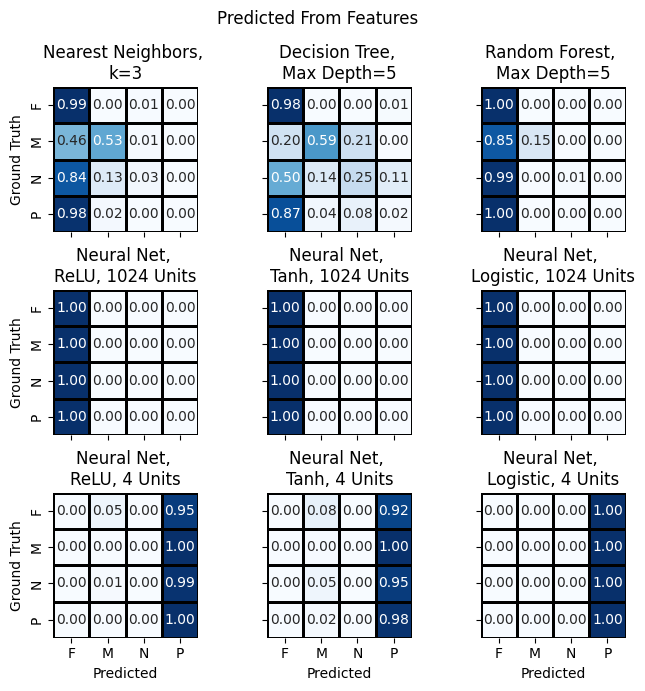

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9177043422733078, 'Decision Tree, \nMax Depth=5': 0.9209770114942529, 'Random Forest, \nMax Depth=5': 0.9150702426564495, 'Neural Net, \nReLU, 1024 Units': 0.9106800766283525, 'Neural Net, \nTanh, 1024 Units': 0.9106800766283525, 'Neural Net, \nLogistic, 1024 Units': 0.9106800766283525, 'Neural Net, \nReLU, 4 Units': 0.013609514687100893, 'Neural Net, \nTanh, 4 Units': 0.01348978288633461, 'Neural Net, \nLogistic, 4 Units': 0.013609514687100893}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.0020029544830322266, 'inference_time_per_sample': 0.00011380213773113557}, 'Decision Tree, \nMax Depth=5': {'train_time': 0.004129648208618164, 'inference_time_per_sample': 1.1258655124240451e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.030455827713012695, 'inference_time_per_sample': 1.162385727406157e-06}, 'Neural Net, \nReLU, 1024 Units': {'train_time': 0.14713668823242188, 'inference_time_per_sample': 2.0759296752179415e-05}, '

In [ ]:
# %1 Train
train_rate = 0.01
print(f".....Train Rate = {train_rate}........\n\n")

# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = logits
y = logits_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))

score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=128, shrink_by=2, suptitle="Predicted From Features")

print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_logit_ellict_pred_1train.csv", index=False)

.....Train Rate = 0.05........



Train set distribution:
 {'full': 1144, 'multiple_objects': 40, 'none': 61, 'partial': 20} Total: 1265

Test set distribution:
 {'full': 21908, 'multiple_objects': 632, 'none': 1177, 'partial': 327} Total: 24044

Train set distribution (%):
 {'full': 0.9043478260869565, 'multiple_objects': 0.03162055335968379, 'none': 0.048221343873517786, 'partial': 0.015810276679841896}

Test set distribution (%):
 {'full': 0.9111628680751954, 'multiple_objects': 0.026285143902844785, 'none': 0.04895192147729163, 'partial': 0.013600066544668108}
Number of features: 8
Wide units: 1024, Narrow units: 4


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9461819996672767
Time:  {'train_time': 0.006307125091552734, 'inference_time_per_sample': 6.82076942184923e-05}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.96      0.99      0.98     21908
multiple_objects       0.69      0.80 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.96      0.98      0.97     21908
multiple_objects       0.79      0.90      0.85       632
            none       0.58      0.48      0.53      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.94     24044
       macro avg       0.59      0.59      0.59     24044
    weighted avg       0.93      0.94      0.94     24044

Decision Tree, 
Max Depth=5 confusion matrix:
[[21544    59   305     0]
 [   30   571    31     0]
 [  531    77   569     0]
 [  247    12    68     0]]
Decision Tree, 
Max Depth=5 normalized confusion matrix:
[[0.98338506 0.00269308 0.01392186 0.        ]
 [0.04746835 0.90348101 0.04905063 0.        ]
 [0.45114698 0.06542056 0.48343246 0.        ]
 [0.75535168 0.03669725 0.20795107 0.        ]]


Random Forest, 
Max Depth=5
Random Forest, 
Max Depth=5 score: 0.93823822991182

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.94      1.00      0.97     21908
multiple_objects       0.98      0.52      0.68       632
            none       0.92      0.29      0.44      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.94     24044
       macro avg       0.71      0.45      0.52     24044
    weighted avg       0.93      0.94      0.92     24044

Random Forest, 
Max Depth=5 confusion matrix:
[[21889     1    18     0]
 [  295   326    11     0]
 [  829     4   344     0]
 [  326     0     1     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99132737e-01 4.56454263e-05 8.21617674e-04 0.00000000e+00]
 [4.66772152e-01 5.15822785e-01 1.74050633e-02 0.00000000e+00]
 [7.04333050e-01 3.39847069e-03 2.92268479e-01 0.00000000e+00]
 [9.96941896e-01 0.00000000e+00 3.05810398e-03 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.91     24044
       macro avg       0.23      0.25      0.24     24044
    weighted avg       0.83      0.91      0.87     24044

Neural Net, 
ReLU, 1024 Units confusion matrix:
[[21908     0     0     0]
 [  632     0     0     0]
 [ 1177     0     0     0]
 [  327     0     0     0]]
Neural Net, 
ReLU, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 1024 Units
Iteration 1, loss = 1.25819195
Validation score: 0.874016
Iteration 2, loss = 0.78357007
Validation score: 0.874016
Iteration 3, loss = 0.53846752
Validation score: 0.8740

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.91     24044
       macro avg       0.23      0.25      0.24     24044
    weighted avg       0.83      0.91      0.87     24044

Neural Net, 
Tanh, 1024 Units confusion matrix:
[[21908     0     0     0]
 [  632     0     0     0]
 [ 1177     0     0     0]
 [  327     0     0     0]]
Neural Net, 
Tanh, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 1024 Units
Iteration 1, loss = 0.75495726
Validation score: 0.874016
Iteration 2, loss = 0.54060518
Validation score: 0.874016
Iteration 3, loss = 0.57954666
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.00      0.00      0.00       327

        accuracy                           0.91     24044
       macro avg       0.23      0.25      0.24     24044
    weighted avg       0.83      0.91      0.87     24044

Neural Net, 
Logistic, 1024 Units confusion matrix:
[[21908     0     0     0]
 [  632     0     0     0]
 [ 1177     0     0     0]
 [  327     0     0     0]]
Neural Net, 
Logistic, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 4 Units
Iteration 1, loss = 1.70600283
Validation score: 0.007874
Iteration 2, loss = 1.67464735
Validation score: 0.007874
Iteration 3, loss = 1.64419975
Validation scor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.01      1.00      0.03       327

        accuracy                           0.01     24044
       macro avg       0.00      0.25      0.01     24044
    weighted avg       0.00      0.01      0.00     24044

Neural Net, 
ReLU, 4 Units confusion matrix:
[[    0  1133     0 20775]
 [    0     1     0   631]
 [    0    18     0  1159]
 [    0     0     0   327]]
Neural Net, 
ReLU, 4 Units normalized confusion matrix:
[[0.         0.05171627 0.         0.94828373]
 [0.         0.00158228 0.         0.99841772]
 [0.         0.01529312 0.         0.98470688]
 [0.         0.         0.         1.        ]]


Neural Net, 
Tanh, 4 Units
Iteration 1, loss = 1.60417245
Validation score: 0.0078

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.01      0.98      0.03       327

        accuracy                           0.01     24044
       macro avg       0.00      0.25      0.01     24044
    weighted avg       0.00      0.01      0.00     24044

Neural Net, 
Tanh, 4 Units confusion matrix:
[[    0  1782     0 20126]
 [    0     3     0   629]
 [    0    61     0  1116]
 [    0     5     0   322]]
Neural Net, 
Tanh, 4 Units normalized confusion matrix:
[[0.         0.08134015 0.         0.91865985]
 [0.         0.00474684 0.         0.99525316]
 [0.         0.05182668 0.         0.94817332]
 [0.         0.01529052 0.         0.98470948]]


Neural Net, 
Logistic, 4 Units
Iteration 1, loss = 1.63854200
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     21908
multiple_objects       0.00      0.00      0.00       632
            none       0.00      0.00      0.00      1177
         partial       0.01      1.00      0.03       327

        accuracy                           0.01     24044
       macro avg       0.00      0.25      0.01     24044
    weighted avg       0.00      0.01      0.00     24044

Neural Net, 
Logistic, 4 Units confusion matrix:
[[    0     0     0 21908]
 [    0     0     0   632]
 [    0     0     0  1177]
 [    0     0     0   327]]
Neural Net, 
Logistic, 4 Units normalized confusion matrix:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


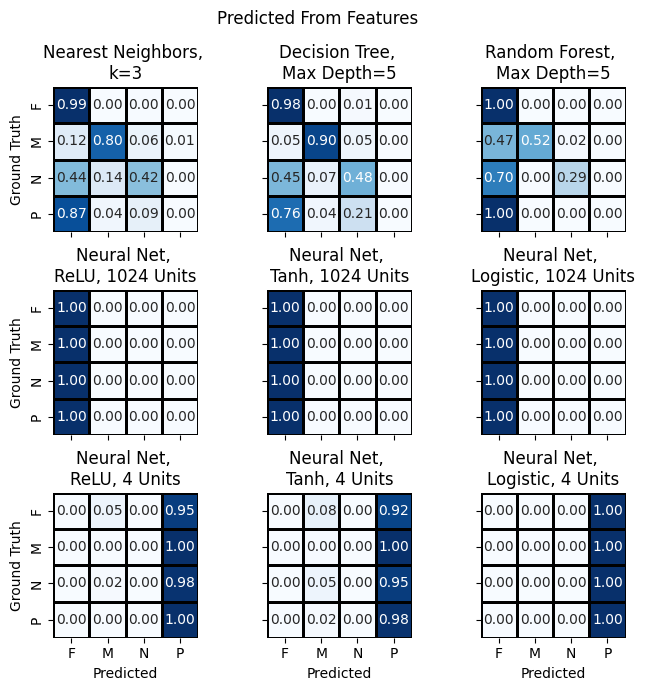

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9461819996672767, 'Decision Tree, \nMax Depth=5': 0.9434370321078024, 'Random Forest, \nMax Depth=5': 0.9382382299118284, 'Neural Net, \nReLU, 1024 Units': 0.9111628680751954, 'Neural Net, \nTanh, 1024 Units': 0.9111628680751954, 'Neural Net, \nLogistic, 1024 Units': 0.9111628680751954, 'Neural Net, \nReLU, 4 Units': 0.0136416569622359, 'Neural Net, \nTanh, 4 Units': 0.013516885709532524, 'Neural Net, \nLogistic, 4 Units': 0.013600066544668108}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.006307125091552734, 'inference_time_per_sample': 6.82076942184923e-05}, 'Decision Tree, \nMax Depth=5': {'train_time': 0.01616048812866211, 'inference_time_per_sample': 1.2778656749633322e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.046404361724853516, 'inference_time_per_sample': 1.262654641011336e-06}, 'Neural Net, \nReLU, 1024 Units': {'train_time': 0.4780004024505615, 'inference_time_per_sample': 9.429046267222454e-06}, 'Neural 

In [ ]:
# %5 Train
train_rate = 0.05
print(f".....Train Rate = {train_rate}........\n\n")

# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = logits
y = logits_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))

score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=128, shrink_by=2, suptitle="Predicted From Features")

print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)# %1 Train


print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_logit_ellict_pred_5train.csv", index=False)

.....Train Rate = 0.1........



Train set distribution:
 {'full': 2287, 'multiple_objects': 75, 'none': 133, 'partial': 35} Total: 2530

Test set distribution:
 {'full': 20765, 'multiple_objects': 597, 'none': 1105, 'partial': 312} Total: 22779

Train set distribution (%):
 {'full': 0.9039525691699605, 'multiple_objects': 0.029644268774703556, 'none': 0.05256916996047431, 'partial': 0.01383399209486166}

Test set distribution (%):
 {'full': 0.9115852320119409, 'multiple_objects': 0.026208349795864613, 'none': 0.04850959216822512, 'partial': 0.013696826023969445}
Number of features: 8
Wide units: 1024, Narrow units: 4


Nearest Neighbors, 
k=3
Nearest Neighbors, 
k=3 score: 0.9497783045787787
Time:  {'train_time': 0.00622105598449707, 'inference_time_per_sample': 0.0002553726531052653}
Nearest Neighbors, 
k=3 classification report:
                  precision    recall  f1-score   support

            full       0.96      0.99      0.98     20765
multiple_objects       0.73      0.79  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest, 
Max Depth=5 classification report:
                  precision    recall  f1-score   support

            full       0.94      1.00      0.97     20765
multiple_objects       0.99      0.57      0.72       597
            none       0.91      0.31      0.46      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.94     22779
       macro avg       0.71      0.47      0.54     22779
    weighted avg       0.93      0.94      0.93     22779

Random Forest, 
Max Depth=5 confusion matrix:
[[20753     0    12     0]
 [  237   339    21     0]
 [  756     4   345     0]
 [  309     0     3     0]]
Random Forest, 
Max Depth=5 normalized confusion matrix:
[[9.99422105e-01 0.00000000e+00 5.77895497e-04 0.00000000e+00]
 [3.96984925e-01 5.67839196e-01 3.51758794e-02 0.00000000e+00]
 [6.84162896e-01 3.61990950e-03 3.12217195e-01 0.00000000e+00]
 [9.90384615e-01 0.00000000e+00 9.61538462e-03 0.00000000e+00]]


Neural Net, 
Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     20765
multiple_objects       0.00      0.00      0.00       597
            none       0.00      0.00      0.00      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.91     22779
       macro avg       0.23      0.25      0.24     22779
    weighted avg       0.83      0.91      0.87     22779

Neural Net, 
ReLU, 1024 Units confusion matrix:
[[20765     0     0     0]
 [  597     0     0     0]
 [ 1105     0     0     0]
 [  312     0     0     0]]
Neural Net, 
ReLU, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Tanh, 1024 Units
Iteration 1, loss = 1.03550210
Validation score: 0.913043
Iteration 2, loss = 0.51707133
Validation score: 0.913043
Iteration 3, loss = 0.45658428
Validation score: 0.9130

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     20765
multiple_objects       0.00      0.00      0.00       597
            none       0.00      0.00      0.00      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.91     22779
       macro avg       0.23      0.25      0.24     22779
    weighted avg       0.83      0.91      0.87     22779

Neural Net, 
Tanh, 1024 Units confusion matrix:
[[20765     0     0     0]
 [  597     0     0     0]
 [ 1105     0     0     0]
 [  312     0     0     0]]
Neural Net, 
Tanh, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 1024 Units
Iteration 1, loss = 0.66248892
Validation score: 0.913043
Iteration 2, loss = 0.54542762
Validation score: 0.913043
Iteration 3, loss = 0.44534881
Validation score: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 1024 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     20765
multiple_objects       0.00      0.00      0.00       597
            none       0.00      0.00      0.00      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.91     22779
       macro avg       0.23      0.25      0.24     22779
    weighted avg       0.83      0.91      0.87     22779

Neural Net, 
Logistic, 1024 Units confusion matrix:
[[20765     0     0     0]
 [  597     0     0     0]
 [ 1105     0     0     0]
 [  312     0     0     0]]
Neural Net, 
Logistic, 1024 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
ReLU, 4 Units
Iteration 1, loss = 1.71015982
Validation score: 0.007905
Iteration 2, loss = 1.64856250
Validation score: 0.007905
Iteration 3, loss = 1.59107812
Validation scor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
ReLU, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     20765
multiple_objects       0.00      0.00      0.00       597
            none       0.00      0.00      0.00      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.91     22779
       macro avg       0.23      0.25      0.24     22779
    weighted avg       0.83      0.91      0.87     22779

Neural Net, 
ReLU, 4 Units confusion matrix:
[[20741     0     0    24]
 [  597     0     0     0]
 [ 1105     0     0     0]
 [  312     0     0     0]]
Neural Net, 
ReLU, 4 Units normalized confusion matrix:
[[0.99884421 0.         0.         0.00115579]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]]


Neural Net, 
Tanh, 4 Units
Iteration 1, loss = 1.60210727
Validation score: 0.0079

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Tanh, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.91      1.00      0.95     20765
multiple_objects       0.00      0.00      0.00       597
            none       0.00      0.00      0.00      1105
         partial       0.00      0.00      0.00       312

        accuracy                           0.91     22779
       macro avg       0.23      0.25      0.24     22779
    weighted avg       0.83      0.91      0.87     22779

Neural Net, 
Tanh, 4 Units confusion matrix:
[[20765     0     0     0]
 [  597     0     0     0]
 [ 1105     0     0     0]
 [  312     0     0     0]]
Neural Net, 
Tanh, 4 Units normalized confusion matrix:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Neural Net, 
Logistic, 4 Units
Iteration 1, loss = 1.62777152
Validation score: 0.007905
Iteration 2, loss = 1.57306669
Validation score: 0.007905
Iteration 3, loss = 1.52013926
Validation score: 0.007905
Itera

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net, 
Logistic, 4 Units classification report:
                  precision    recall  f1-score   support

            full       0.00      0.00      0.00     20765
multiple_objects       0.00      0.00      0.00       597
            none       0.00      0.00      0.00      1105
         partial       0.01      1.00      0.03       312

        accuracy                           0.01     22779
       macro avg       0.00      0.25      0.01     22779
    weighted avg       0.00      0.01      0.00     22779

Neural Net, 
Logistic, 4 Units confusion matrix:
[[    0     0     0 20765]
 [    0     0     0   597]
 [    0     0     0  1105]
 [    0     0     0   312]]
Neural Net, 
Logistic, 4 Units normalized confusion matrix:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


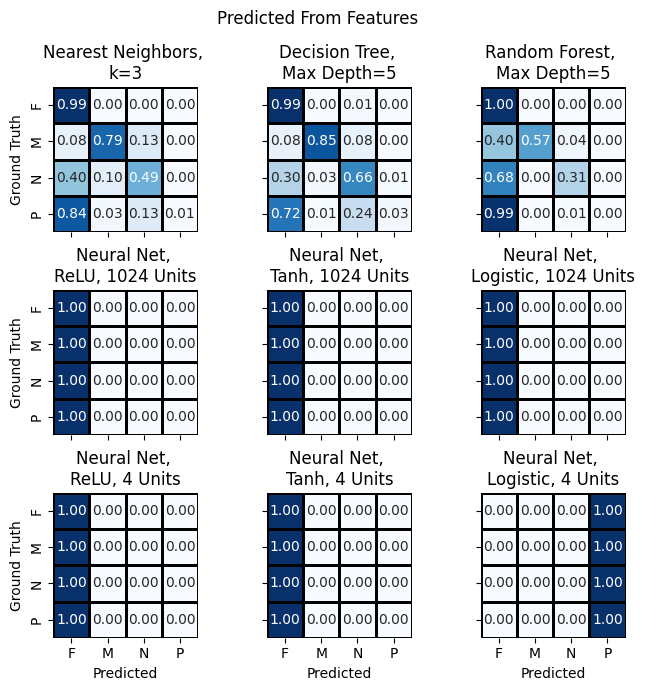

score_dict: 
 {'Nearest Neighbors, \nk=3': 0.9497783045787787, 'Decision Tree, \nMax Depth=5': 0.9527635102506695, 'Random Forest, \nMax Depth=5': 0.9410860880635673, 'Neural Net, \nReLU, 1024 Units': 0.9115852320119409, 'Neural Net, \nTanh, 1024 Units': 0.9115852320119409, 'Neural Net, \nLogistic, 1024 Units': 0.9115852320119409, 'Neural Net, \nReLU, 4 Units': 0.9105316300100971, 'Neural Net, \nTanh, 4 Units': 0.9115852320119409, 'Neural Net, \nLogistic, 4 Units': 0.013696826023969445}
times_dict: 
 {'Nearest Neighbors, \nk=3': {'train_time': 0.00622105598449707, 'inference_time_per_sample': 0.0002553726531052653}, 'Decision Tree, \nMax Depth=5': {'train_time': 0.026862382888793945, 'inference_time_per_sample': 1.1871212626409948e-07}, 'Random Forest, \nMax Depth=5': {'train_time': 0.0628976821899414, 'inference_time_per_sample': 1.3662047118015257e-06}, 'Neural Net, \nReLU, 1024 Units': {'train_time': 0.7735354900360107, 'inference_time_per_sample': 1.2021690870044135e-05}, 'Neural N

In [ ]:
# %10 Train
train_rate = 0.1
print(f".....Train Rate = {train_rate}........\n\n")

# PREDICT FROM FEATURES
#X = np.array(features_df['features'].tolist()) # BAK! Bu da güzel çalışıyor???
X = logits
y = logits_df['bbox_coverage'].tolist()

# Shuffle
"""indices = np.arange(len(X))
np.random.shuffle(indices)
np.save(savepath+"shuffle_indices.npy", indices)"""
indices = np.load(savepath+"shuffle_indices.npy")
X = X[indices]
y = np.array(y)[indices]

# Partition
X_train = X[:int(train_rate*len(X))]
X_test = X[int(train_rate*len(X)):]

y_train = y[:int(train_rate*len(y))]
y_test = y[int(train_rate*len(y)):]


# Class distributions
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:\n", dict(zip(unique, counts)), "Total:", sum(counts))

# Class distributions in percentage
unique, counts = np.unique(y_train, return_counts=True)
print("\nTrain set distribution (%):\n", dict(zip(unique, counts/len(y_train))))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution (%):\n", dict(zip(unique, counts/len(y_test))))

score_dict, pred_dict, times_dict = classifier_ellicitation(X_train, X_test, y_train, y_test,
                                                            widen_by=128, shrink_by=2, suptitle="Predicted From Features")

print("score_dict: \n",score_dict)
print("times_dict: \n", times_dict)

pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv(savepath+"resnet50_classification_logit_ellict_pred_10train.csv", index=False)